In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 4:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]),
                          len(answer_positions["C"]), len(answer_positions["D"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=96.9, y1=127.3
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 188
Page 1, Q1, A: Yellow percentage: 0.0%


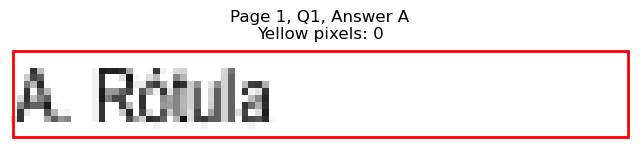

Page 1, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=109.0, y1=139.9
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 266
Page 1, Q1, B: Yellow percentage: 0.0%


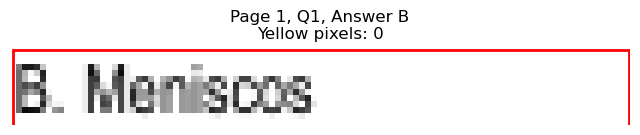

Page 1, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=402.3, y1=127.3
Page 1, Q1, C: Yellow pixels: 1367
Page 1, Q1, C: Total non-white pixels: 1932
Page 1, Q1, C: Yellow percentage: 70.8%


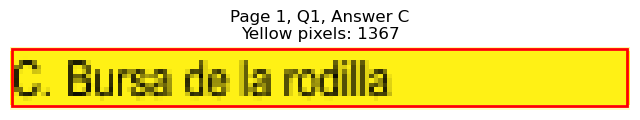

Page 1, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=406.7, y1=139.9
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 548
Page 1, Q1, D: Yellow percentage: 0.0%


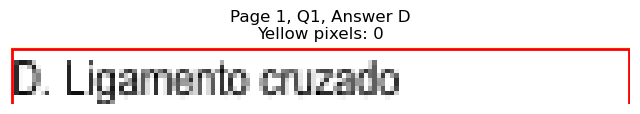


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)
Page 1, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=160.1, y1=203.0
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 531
Page 1, Q2, A: Yellow percentage: 0.0%


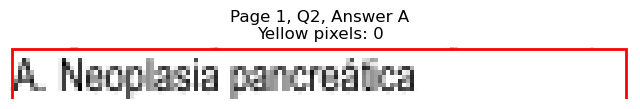

Page 1, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=213.3, y1=215.6
Page 1, Q2, B: Yellow pixels: 0
Page 1, Q2, B: Total non-white pixels: 764
Page 1, Q2, B: Yellow percentage: 0.0%


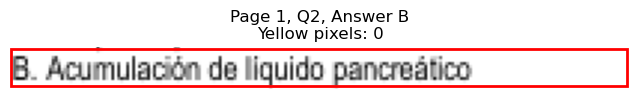

Page 1, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=448.4, y1=203.0
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 823
Page 1, Q2, C: Yellow percentage: 0.0%


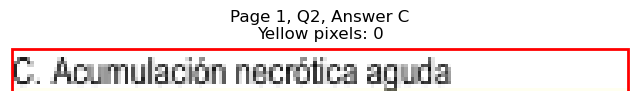

Page 1, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=429.4, y1=215.6
Page 1, Q2, D: Yellow pixels: 1718
Page 1, Q2, D: Total non-white pixels: 2310
Page 1, Q2, D: Yellow percentage: 74.4%


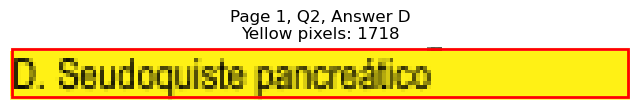


Page 1, Q2 - Selected Answer: D (based on yellow pixel count)
Page 1, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=115.0, y1=266.1
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 251
Page 1, Q3, A: Yellow percentage: 0.0%


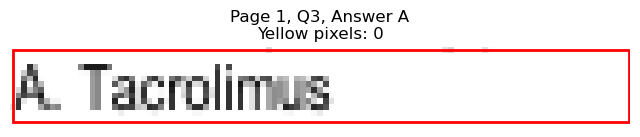

Page 1, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=103.0, y1=278.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 198
Page 1, Q3, B: Yellow percentage: 0.0%


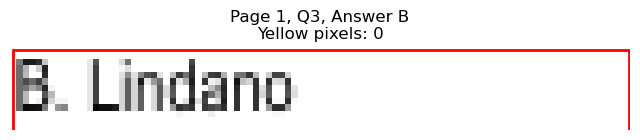

Page 1, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=399.3, y1=266.1
Page 1, Q3, C: Yellow pixels: 1470
Page 1, Q3, C: Total non-white pixels: 1890
Page 1, Q3, C: Yellow percentage: 77.8%


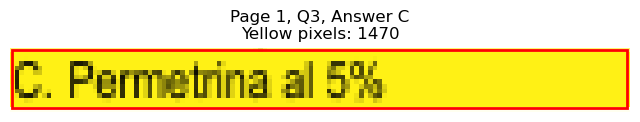

Page 1, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=407.3, y1=278.7
Page 1, Q3, D: Yellow pixels: 0
Page 1, Q3, D: Total non-white pixels: 574
Page 1, Q3, D: Yellow percentage: 0.0%


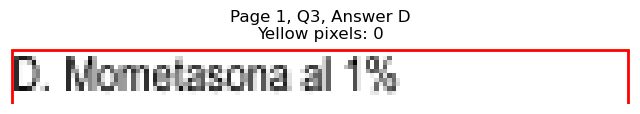


Page 1, Q3 - Selected Answer: C (based on yellow pixel count)
Page 1, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=88.3, y1=329.2
Page 1, Q4, A: Yellow pixels: 889
Page 1, Q4, A: Total non-white pixels: 1162
Page 1, Q4, A: Yellow percentage: 76.5%


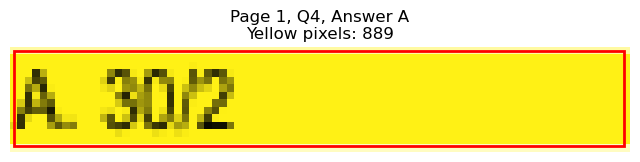

Page 1, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=88.3, y1=341.8
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 213
Page 1, Q4, B: Yellow percentage: 0.0%


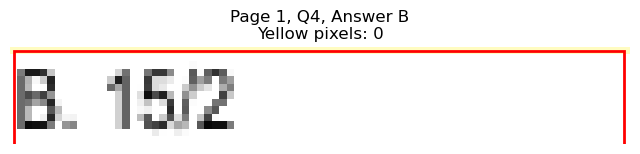

Page 1, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=347.6, y1=329.2
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 126
Page 1, Q4, C: Yellow percentage: 0.0%


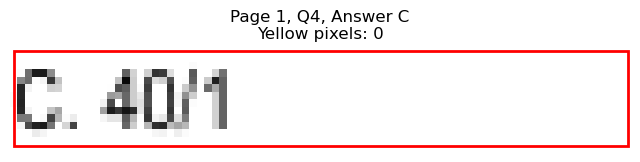

Page 1, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=347.6, y1=341.8
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 139
Page 1, Q4, D: Yellow percentage: 0.0%


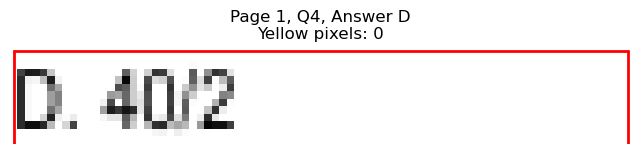


Page 1, Q4 - Selected Answer: A (based on yellow pixel count)
Page 1, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=150.0, y1=405.0
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 562
Page 1, Q5, A: Yellow percentage: 0.0%


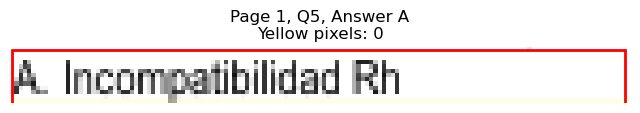

Page 1, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=150.6, y1=417.6
Page 1, Q5, B: Yellow pixels: 1545
Page 1, Q5, B: Total non-white pixels: 2030
Page 1, Q5, B: Yellow percentage: 76.1%


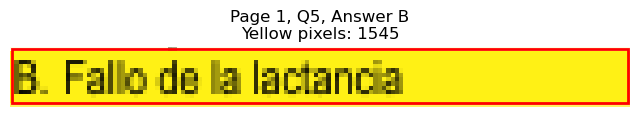

Page 1, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=395.2, y1=405.0
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 409
Page 1, Q5, C: Yellow percentage: 0.0%


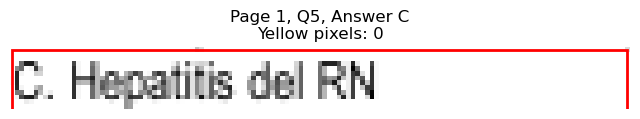

Page 1, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=398.7, y1=417.6
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 397
Page 1, Q5, D: Yellow percentage: 0.0%


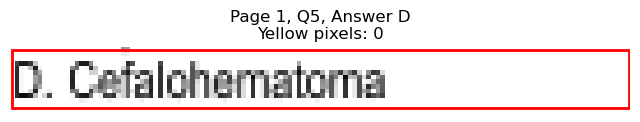


Page 1, Q5 - Selected Answer: B (based on yellow pixel count)
Page 1, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=160.6, y1=493.4
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 508
Page 1, Q6, A: Yellow percentage: 0.0%


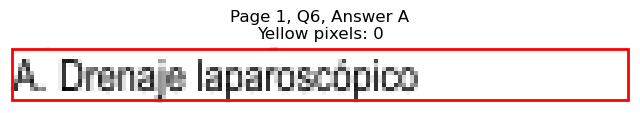

Page 1, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=135.5, y1=506.0
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 392
Page 1, Q6, B: Yellow percentage: 0.0%


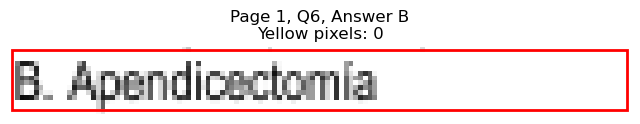

Page 1, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=409.3, y1=493.4
Page 1, Q6, C: Yellow pixels: 145
Page 1, Q6, C: Total non-white pixels: 601
Page 1, Q6, C: Yellow percentage: 24.1%


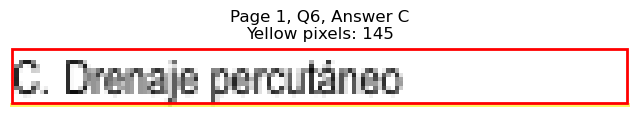

Page 1, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=399.3, y1=506.0
Page 1, Q6, D: Yellow pixels: 1427
Page 1, Q6, D: Total non-white pixels: 1756
Page 1, Q6, D: Yellow percentage: 81.3%


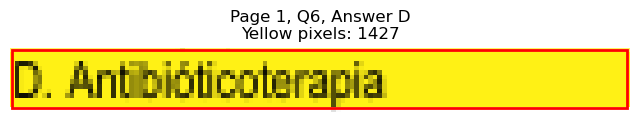


Page 1, Q6 - Selected Answer: D (based on yellow pixel count)
Page 1, Q7 - A: Detected box: x0=56.6, y0=581.7, x1=116.4, y1=594.3
Page 1, Q7, A: Yellow pixels: 1112
Page 1, Q7, A: Total non-white pixels: 1554
Page 1, Q7, A: Yellow percentage: 71.6%


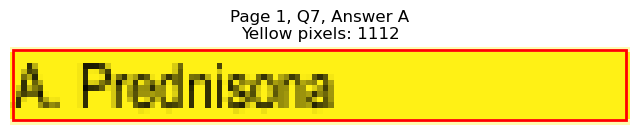

Page 1, Q7 - B: Detected box: x0=56.6, y0=594.3, x1=133.0, y1=606.9
Page 1, Q7, B: Yellow pixels: 0
Page 1, Q7, B: Total non-white pixels: 494
Page 1, Q7, B: Yellow percentage: 0.0%


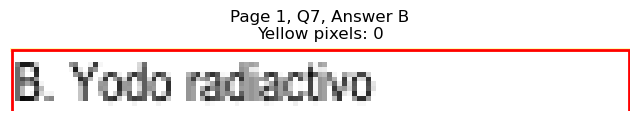

Page 1, Q7 - C: Detected box: x0=315.4, y0=581.7, x1=371.2, y1=594.3
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 258
Page 1, Q7, C: Yellow percentage: 0.0%


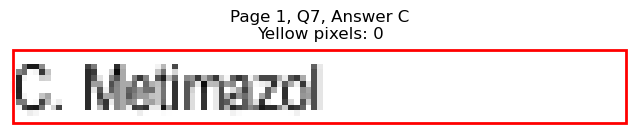

Page 1, Q7 - D: Detected box: x0=315.4, y0=594.3, x1=373.1, y1=606.9
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 265
Page 1, Q7, D: Yellow percentage: 0.0%


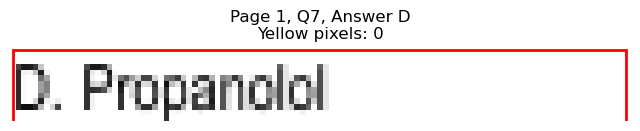


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)
Page 1, Q8 - A: Detected box: x0=56.6, y0=657.4, x1=163.6, y1=670.1
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 532
Page 1, Q8, A: Yellow percentage: 0.0%


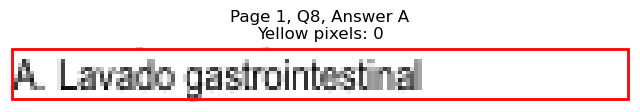

Page 1, Q8 - B: Detected box: x0=56.6, y0=670.0, x1=121.5, y1=682.7
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 320
Page 1, Q8, B: Yellow percentage: 0.0%


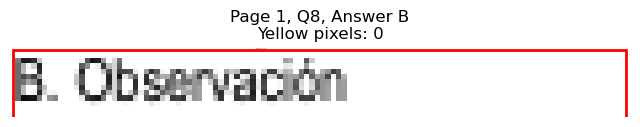

Page 1, Q8 - C: Detected box: x0=315.4, y0=657.4, x1=415.9, y1=670.1
Page 1, Q8, C: Yellow pixels: 151
Page 1, Q8, C: Total non-white pixels: 638
Page 1, Q8, C: Yellow percentage: 23.7%


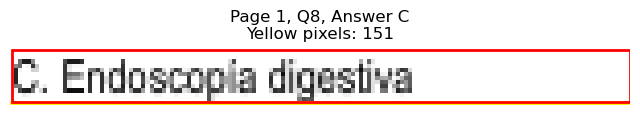

Page 1, Q8 - D: Detected box: x0=315.4, y0=670.0, x1=426.9, y1=682.7
Page 1, Q8, D: Yellow pixels: 1678
Page 1, Q8, D: Total non-white pixels: 2106
Page 1, Q8, D: Yellow percentage: 79.7%


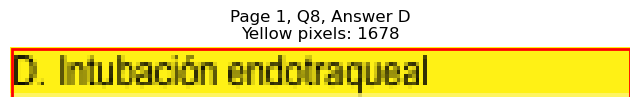


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)
Page 1, Q9 - A: Detected box: x0=56.6, y0=733.2, x1=198.6, y1=745.8
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 678
Page 1, Q9, A: Yellow percentage: 0.0%


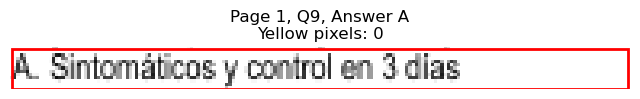

Page 1, Q9 - B: Detected box: x0=56.6, y0=745.8, x1=188.7, y1=758.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 635
Page 1, Q9, B: Yellow percentage: 0.0%


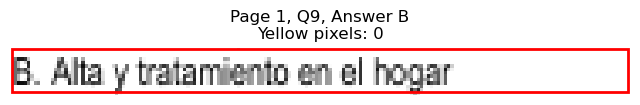

Page 1, Q9 - C: Detected box: x0=315.4, y0=733.2, x1=523.7, y1=745.8
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 1286
Page 1, Q9, C: Yellow percentage: 0.0%


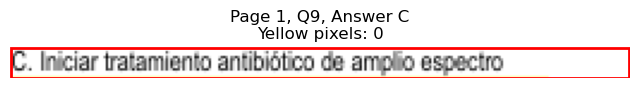

Page 1, Q9 - D: Detected box: x0=315.4, y0=745.8, x1=534.6, y1=758.4
Page 1, Q9, D: Yellow pixels: 2062
Page 1, Q9, D: Total non-white pixels: 3164
Page 1, Q9, D: Yellow percentage: 65.2%


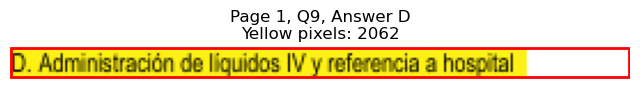


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)

Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=118.9, y1=127.3
Page 2, Q1, A: Yellow pixels: 113
Page 2, Q1, A: Total non-white pixels: 402
Page 2, Q1, A: Yellow percentage: 28.1%


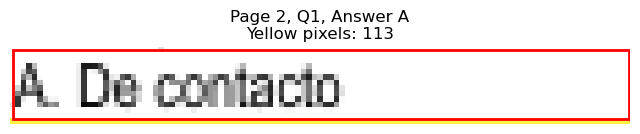

Page 2, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=114.0, y1=139.9
Page 2, Q1, B: Yellow pixels: 1208
Page 2, Q1, B: Total non-white pixels: 1417
Page 2, Q1, B: Yellow percentage: 85.3%


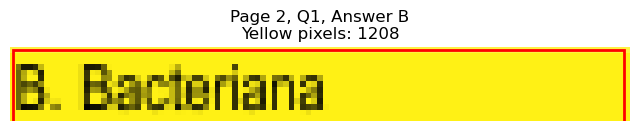

Page 2, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=374.2, y1=127.3
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 273
Page 2, Q1, C: Yellow percentage: 0.0%


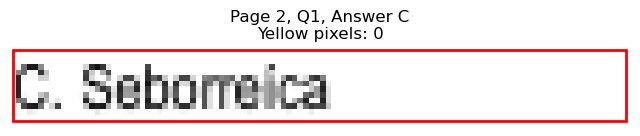

Page 2, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=381.7, y1=139.9
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 341
Page 2, Q1, D: Yellow percentage: 0.0%


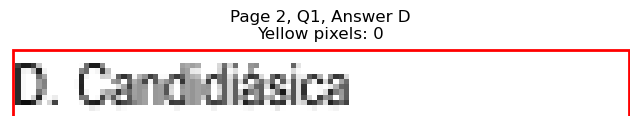


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)
Page 2, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=77.3, y1=177.8
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 73
Page 2, Q2, A: Yellow percentage: 0.0%


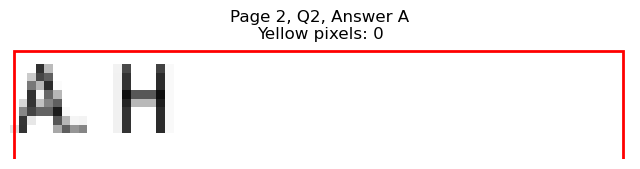

Page 2, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=101.4, y1=190.4
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 225
Page 2, Q2, B: Yellow percentage: 0.0%


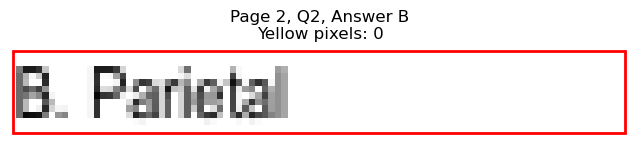

Page 2, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=364.6, y1=177.8
Page 2, Q2, C: Yellow pixels: 1132
Page 2, Q2, C: Total non-white pixels: 1300
Page 2, Q2, C: Yellow percentage: 87.1%


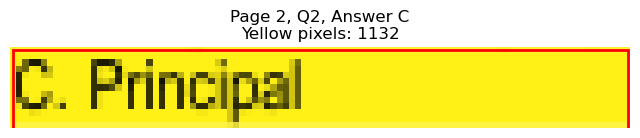

Page 2, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=337.1, y1=190.4
Page 2, Q2, D: Yellow pixels: 73
Page 2, Q2, D: Total non-white pixels: 148
Page 2, Q2, D: Yellow percentage: 49.3%


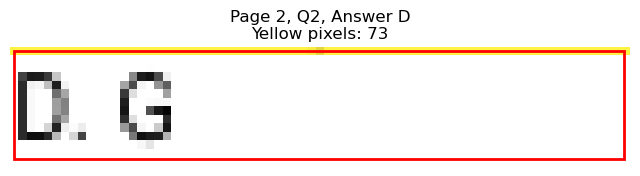


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)
Page 2, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=118.9, y1=278.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 291
Page 2, Q3, A: Yellow percentage: 0.0%


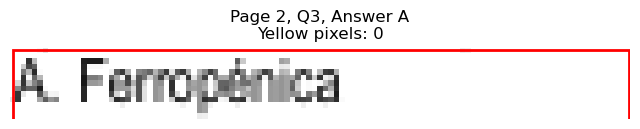

Page 2, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=104.9, y1=291.4
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 244
Page 2, Q3, B: Yellow percentage: 0.0%


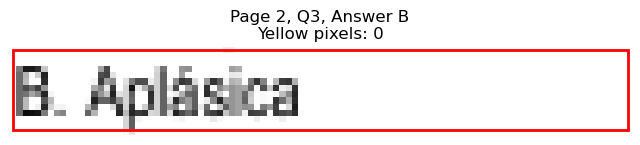

Page 2, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=372.7, y1=278.7
Page 2, Q3, C: Yellow pixels: 0
Page 2, Q3, C: Total non-white pixels: 261
Page 2, Q3, C: Yellow percentage: 0.0%


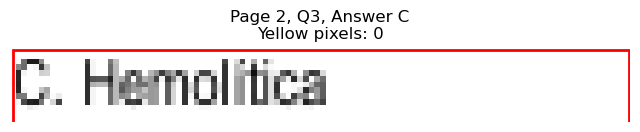

Page 2, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=390.2, y1=291.4
Page 2, Q3, D: Yellow pixels: 1309
Page 2, Q3, D: Total non-white pixels: 1764
Page 2, Q3, D: Yellow percentage: 74.2%


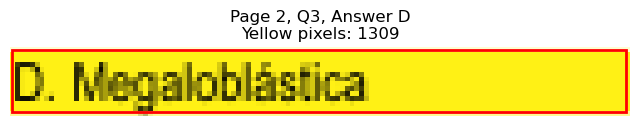


Page 2, Q3 - Selected Answer: D (based on yellow pixel count)
Page 2, Q4 - A: Detected box: x0=56.6, y0=354.5, x1=172.1, y1=367.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 590
Page 2, Q4, A: Yellow percentage: 0.0%


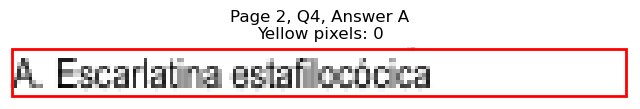

Page 2, Q4 - B: Detected box: x0=56.6, y0=367.1, x1=173.7, y1=379.8
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 571
Page 2, Q4, B: Yellow percentage: 0.0%


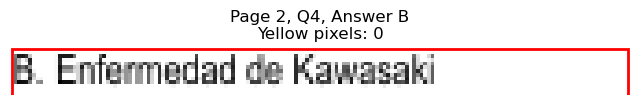

Page 2, Q4 - C: Detected box: x0=315.4, y0=354.5, x1=432.9, y1=367.2
Page 2, Q4, C: Yellow pixels: 168
Page 2, Q4, C: Total non-white pixels: 748
Page 2, Q4, C: Yellow percentage: 22.5%


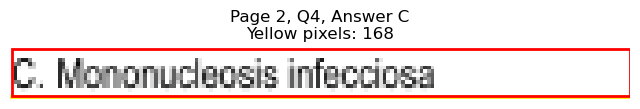

Page 2, Q4 - D: Detected box: x0=315.4, y0=367.1, x1=435.4, y1=379.8
Page 2, Q4, D: Yellow pixels: 1756
Page 2, Q4, D: Total non-white pixels: 2223
Page 2, Q4, D: Yellow percentage: 79.0%


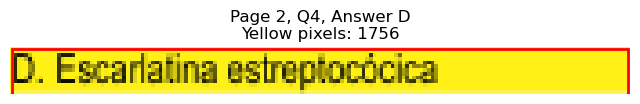


Page 2, Q4 - Selected Answer: D (based on yellow pixel count)
Page 2, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=73.3, y1=430.3
Page 2, Q5, A: Yellow pixels: 68
Page 2, Q5, A: Total non-white pixels: 113
Page 2, Q5, A: Yellow percentage: 60.2%


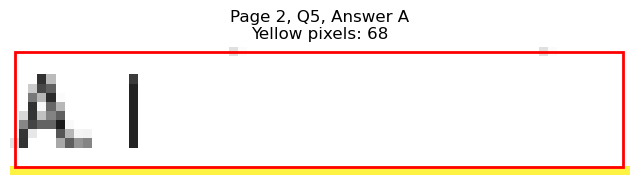

Page 2, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=78.4, y1=442.9
Page 2, Q5, B: Yellow pixels: 880
Page 2, Q5, B: Total non-white pixels: 949
Page 2, Q5, B: Yellow percentage: 92.7%


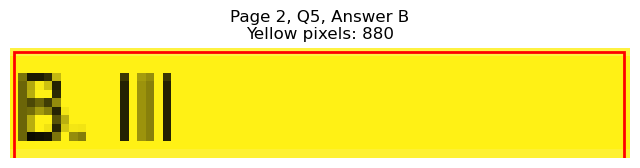

Page 2, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=338.6, y1=430.3
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 82
Page 2, Q5, C: Yellow percentage: 0.0%


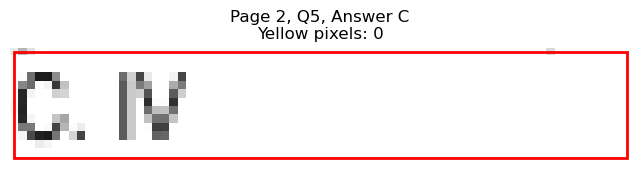

Page 2, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=335.1, y1=442.9
Page 2, Q5, D: Yellow pixels: 0
Page 2, Q5, D: Total non-white pixels: 72
Page 2, Q5, D: Yellow percentage: 0.0%


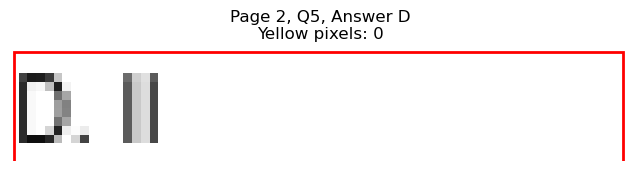


Page 2, Q5 - Selected Answer: B (based on yellow pixel count)
Page 2, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=113.4, y1=493.4
Page 2, Q6, A: Yellow pixels: 1068
Page 2, Q6, A: Total non-white pixels: 1512
Page 2, Q6, A: Yellow percentage: 70.6%


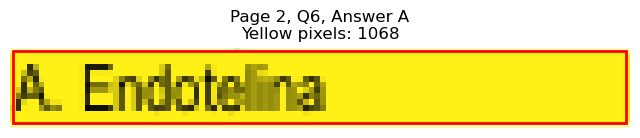

Page 2, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=121.5, y1=506.0
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 409
Page 2, Q6, B: Yellow percentage: 0.0%


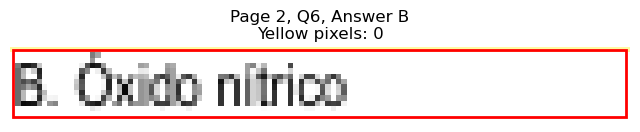

Page 2, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=378.2, y1=493.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 281
Page 2, Q6, C: Yellow percentage: 0.0%


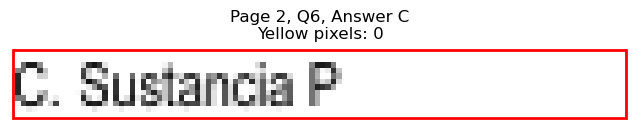

Page 2, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=370.1, y1=506.0
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 272
Page 2, Q6, D: Yellow percentage: 0.0%


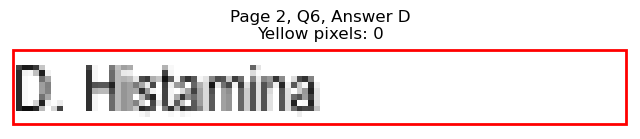


Page 2, Q6 - Selected Answer: A (based on yellow pixel count)
Page 2, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=154.1, y1=556.4
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 478
Page 2, Q7, A: Yellow percentage: 0.0%


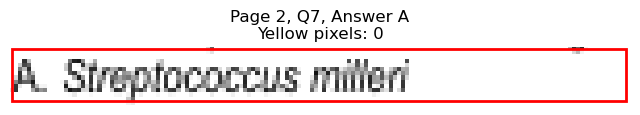

Page 2, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=167.1, y1=569.1
Page 2, Q7, B: Yellow pixels: 0
Page 2, Q7, B: Total non-white pixels: 549
Page 2, Q7, B: Yellow percentage: 0.0%


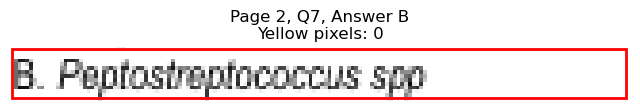

Page 2, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=394.7, y1=556.4
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 404
Page 2, Q7, C: Yellow percentage: 0.0%


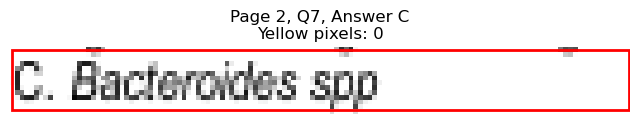

Page 2, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=423.3, y1=569.1
Page 2, Q7, D: Yellow pixels: 1671
Page 2, Q7, D: Total non-white pixels: 2226
Page 2, Q7, D: Yellow percentage: 75.1%


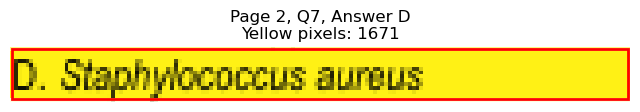


Page 2, Q7 - Selected Answer: D (based on yellow pixel count)
Page 2, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=110.4, y1=644.9
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 233
Page 2, Q8, A: Yellow percentage: 0.0%


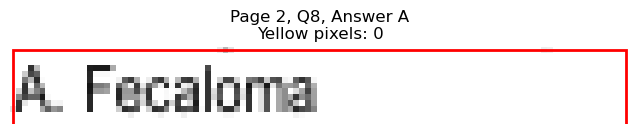

Page 2, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=156.0, y1=657.5
Page 2, Q8, B: Yellow pixels: 0
Page 2, Q8, B: Total non-white pixels: 485
Page 2, Q8, B: Yellow percentage: 0.0%


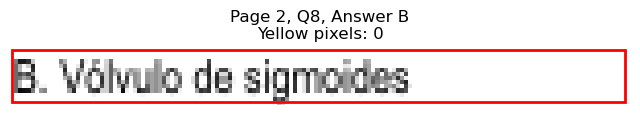

Page 2, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=441.9, y1=644.9
Page 2, Q8, C: Yellow pixels: 1843
Page 2, Q8, C: Total non-white pixels: 2301
Page 2, Q8, C: Yellow percentage: 80.1%


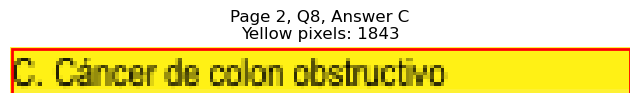

Page 2, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=418.9, y1=657.5
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 523
Page 2, Q8, D: Yellow percentage: 0.0%


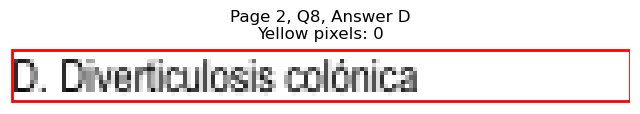


Page 2, Q8 - Selected Answer: C (based on yellow pixel count)
Page 2, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=105.4, y1=708.0
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 215
Page 2, Q9, A: Yellow percentage: 0.0%


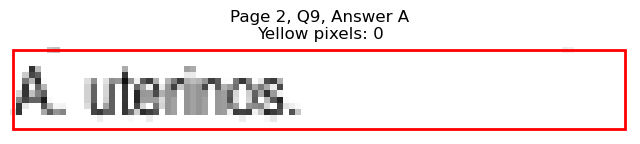

Page 2, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=113.4, y1=720.6
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 257
Page 2, Q9, B: Yellow percentage: 0.0%


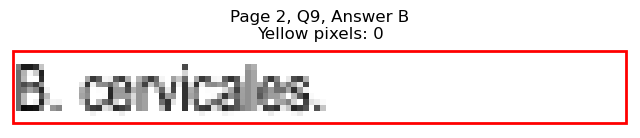

Page 2, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=366.2, y1=708.0
Page 2, Q9, C: Yellow pixels: 1159
Page 2, Q9, C: Total non-white pixels: 1326
Page 2, Q9, C: Yellow percentage: 87.4%


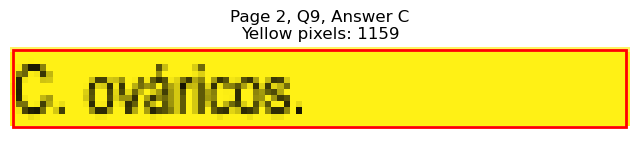

Page 2, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=367.2, y1=720.6
Page 2, Q9, D: Yellow pixels: 103
Page 2, Q9, D: Total non-white pixels: 357
Page 2, Q9, D: Yellow percentage: 28.9%


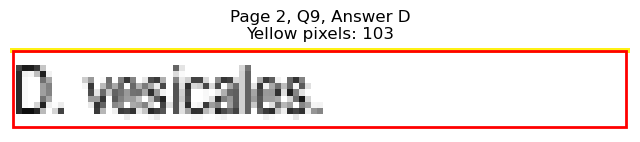


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)

Page 3: Found 9 questions
Page 3, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=138.5, y1=114.7
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 406
Page 3, Q1, A: Yellow percentage: 0.0%


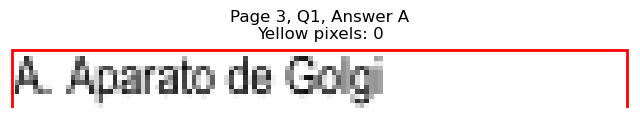

Page 3, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=115.9, y1=127.3
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 296
Page 3, Q1, B: Yellow percentage: 0.0%


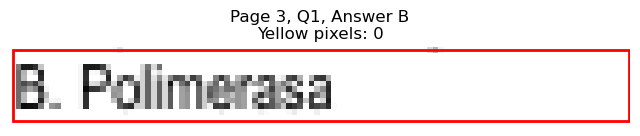

Page 3, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=380.2, y1=114.7
Page 3, Q1, C: Yellow pixels: 1273
Page 3, Q1, C: Total non-white pixels: 1508
Page 3, Q1, C: Yellow percentage: 84.4%


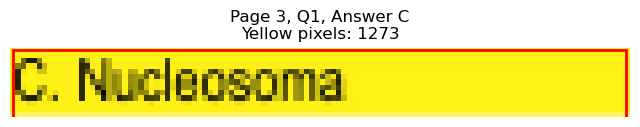

Page 3, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=378.2, y1=127.3
Page 3, Q1, D: Yellow pixels: 114
Page 3, Q1, D: Total non-white pixels: 394
Page 3, Q1, D: Yellow percentage: 28.9%


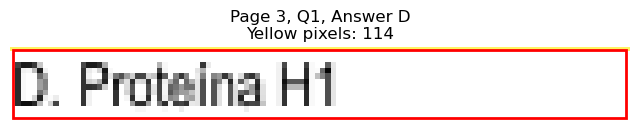


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)
Page 3, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=172.1, y1=190.4
Page 3, Q2, A: Yellow pixels: 167
Page 3, Q2, A: Total non-white pixels: 663
Page 3, Q2, A: Yellow percentage: 25.2%


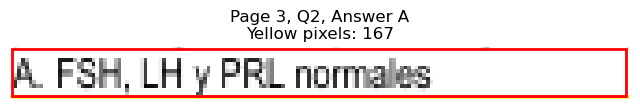

Page 3, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=182.7, y1=203.0
Page 3, Q2, B: Yellow pixels: 1879
Page 3, Q2, B: Total non-white pixels: 2301
Page 3, Q2, B: Yellow percentage: 81.7%


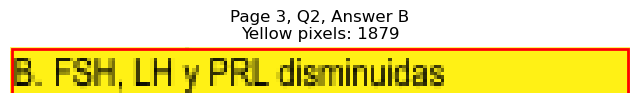

Page 3, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=430.4, y1=190.4
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 509
Page 3, Q2, C: Yellow percentage: 0.0%


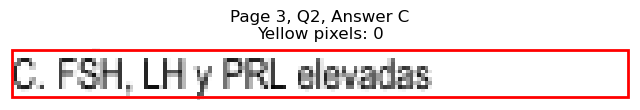

Page 3, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=489.6, y1=203.0
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 822
Page 3, Q2, D: Yellow percentage: 0.0%


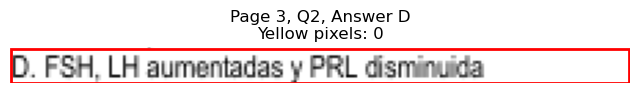


Page 3, Q2 - Selected Answer: B (based on yellow pixel count)
Page 3, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=122.4, y1=266.1
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 318
Page 3, Q3, A: Yellow percentage: 0.0%


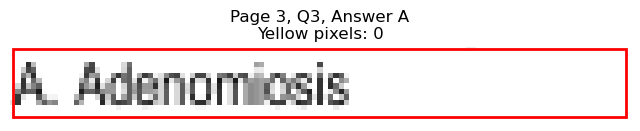

Page 3, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=165.6, y1=278.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 571
Page 3, Q3, B: Yellow percentage: 0.0%


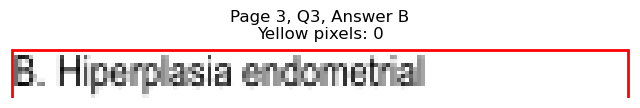

Page 3, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=404.8, y1=266.1
Page 3, Q3, C: Yellow pixels: 140
Page 3, Q3, C: Total non-white pixels: 572
Page 3, Q3, C: Yellow percentage: 24.5%


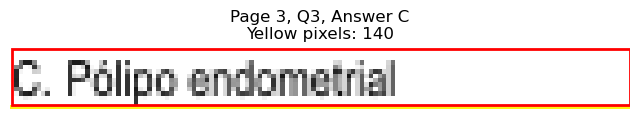

Page 3, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=449.5, y1=278.7
Page 3, Q3, D: Yellow pixels: 1887
Page 3, Q3, D: Total non-white pixels: 2405
Page 3, Q3, D: Yellow percentage: 78.5%


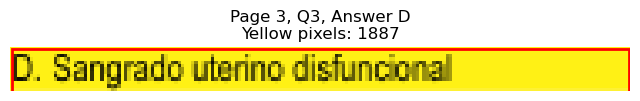


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)
Page 3, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=152.5, y1=329.2
Page 3, Q4, A: Yellow pixels: 1412
Page 3, Q4, A: Total non-white pixels: 2058
Page 3, Q4, A: Yellow percentage: 68.6%


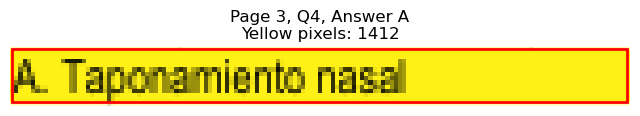

Page 3, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=121.0, y1=341.8
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 424
Page 3, Q4, B: Yellow percentage: 0.0%


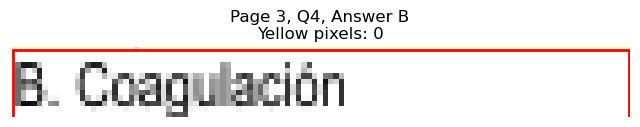

Page 3, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=373.7, y1=329.2
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 259
Page 3, Q4, C: Yellow percentage: 0.0%


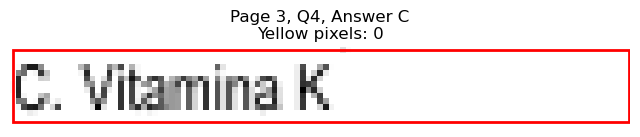

Page 3, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=385.3, y1=341.8
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 344
Page 3, Q4, D: Yellow percentage: 0.0%


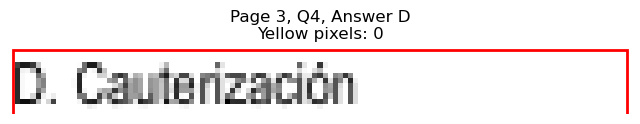


Page 3, Q4 - Selected Answer: A (based on yellow pixel count)
Page 3, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=130.5, y1=405.0
Page 3, Q5, A: Yellow pixels: 1321
Page 3, Q5, A: Total non-white pixels: 1625
Page 3, Q5, A: Yellow percentage: 81.3%


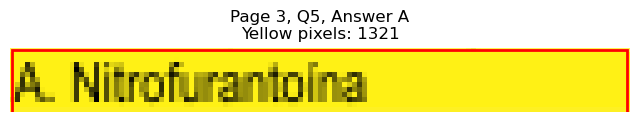

Page 3, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=116.9, y1=417.6
Page 3, Q5, B: Yellow pixels: 111
Page 3, Q5, B: Total non-white pixels: 394
Page 3, Q5, B: Yellow percentage: 28.2%


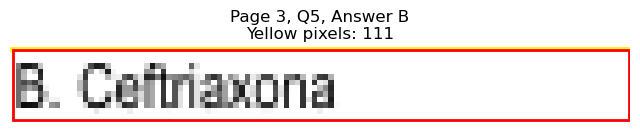

Page 3, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=368.7, y1=405.0
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 248
Page 3, Q5, C: Yellow percentage: 0.0%


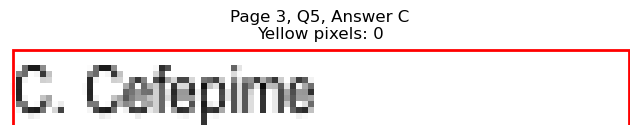

Page 3, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=375.7, y1=417.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 295
Page 3, Q5, D: Yellow percentage: 0.0%


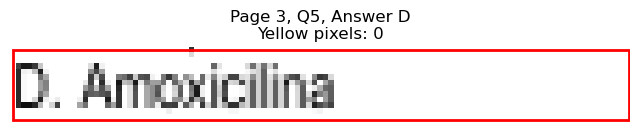


Page 3, Q5 - Selected Answer: A (based on yellow pixel count)
Page 3, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=136.0, y1=493.4
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 376
Page 3, Q6, A: Yellow percentage: 0.0%


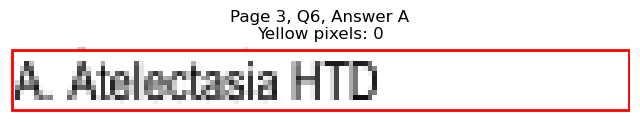

Page 3, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=135.5, y1=506.0
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 388
Page 3, Q6, B: Yellow percentage: 0.0%


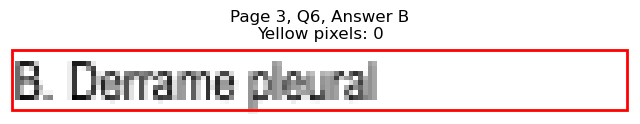

Page 3, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=391.3, y1=493.4
Page 3, Q6, C: Yellow pixels: 127
Page 3, Q6, C: Total non-white pixels: 493
Page 3, Q6, C: Yellow percentage: 25.8%


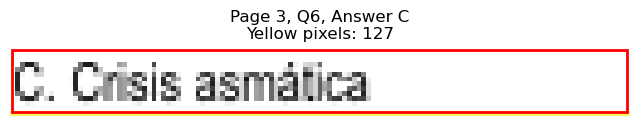

Page 3, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=440.3, y1=506.0
Page 3, Q6, D: Yellow pixels: 1813
Page 3, Q6, D: Total non-white pixels: 2288
Page 3, Q6, D: Yellow percentage: 79.2%


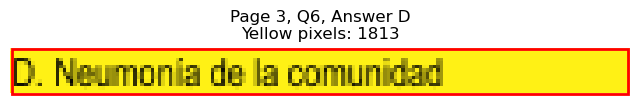


Page 3, Q6 - Selected Answer: D (based on yellow pixel count)
Page 3, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=222.8, y1=569.1
Page 3, Q7, A: Yellow pixels: 2186
Page 3, Q7, A: Total non-white pixels: 3038
Page 3, Q7, A: Yellow percentage: 72.0%


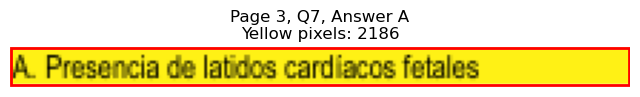

Page 3, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=236.8, y1=581.7
Page 3, Q7, B: Yellow pixels: 0
Page 3, Q7, B: Total non-white pixels: 1095
Page 3, Q7, B: Yellow percentage: 0.0%


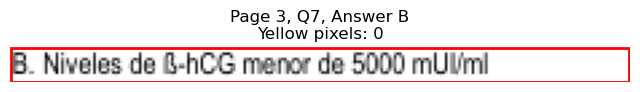

Page 3, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=461.5, y1=569.1
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 670
Page 3, Q7, C: Yellow percentage: 0.0%


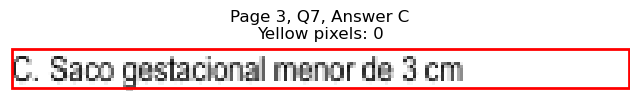

Page 3, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=430.9, y1=581.7
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 572
Page 3, Q7, D: Yellow percentage: 0.0%


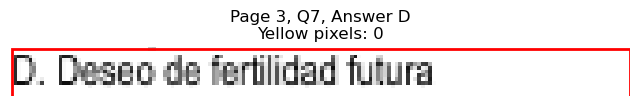


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)
Page 3, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=91.8, y1=644.9
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 151
Page 3, Q8, A: Yellow percentage: 0.0%


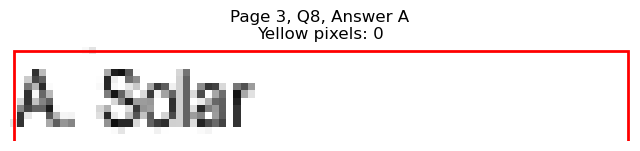

Page 3, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=109.0, y1=657.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 249
Page 3, Q8, B: Yellow percentage: 0.0%


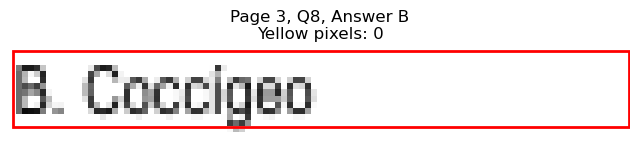

Page 3, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=353.6, y1=644.9
Page 3, Q8, C: Yellow pixels: 1037
Page 3, Q8, C: Total non-white pixels: 1157
Page 3, Q8, C: Yellow percentage: 89.6%


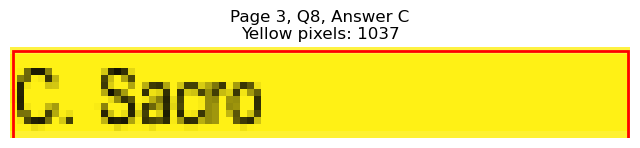

Page 3, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=360.7, y1=657.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 177
Page 3, Q8, D: Yellow percentage: 0.0%


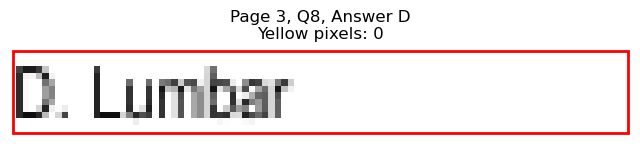


Page 3, Q8 - Selected Answer: C (based on yellow pixel count)
Page 3, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=148.6, y1=708.0
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 406
Page 3, Q9, A: Yellow percentage: 0.0%


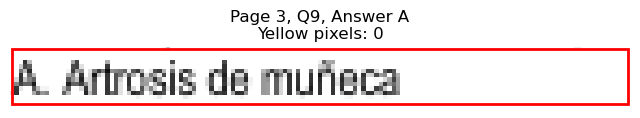

Page 3, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=144.0, y1=720.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 417
Page 3, Q9, B: Yellow percentage: 0.0%


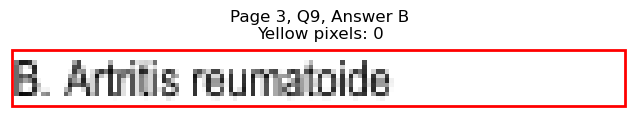

Page 3, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=442.9, y1=708.0
Page 3, Q9, C: Yellow pixels: 178
Page 3, Q9, C: Total non-white pixels: 973
Page 3, Q9, C: Yellow percentage: 18.3%


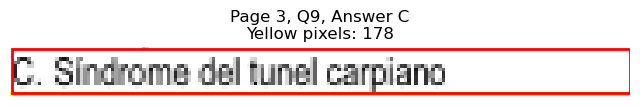

Page 3, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=434.3, y1=720.6
Page 3, Q9, D: Yellow pixels: 1789
Page 3, Q9, D: Total non-white pixels: 2380
Page 3, Q9, D: Yellow percentage: 75.2%


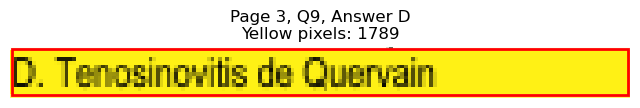


Page 3, Q9 - Selected Answer: D (based on yellow pixel count)

Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=110.9, y1=127.3
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 257
Page 4, Q1, A: Yellow percentage: 0.0%


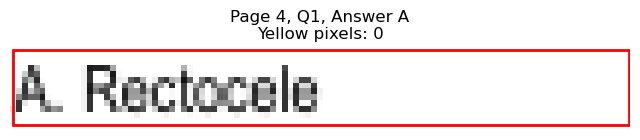

Page 4, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=154.1, y1=139.9
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 493
Page 4, Q1, B: Yellow percentage: 0.0%


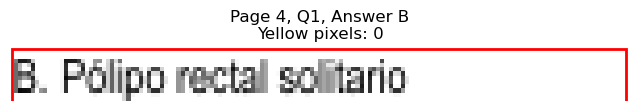

Page 4, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=424.4, y1=127.3
Page 4, Q1, C: Yellow pixels: 160
Page 4, Q1, C: Total non-white pixels: 660
Page 4, Q1, C: Yellow percentage: 24.2%


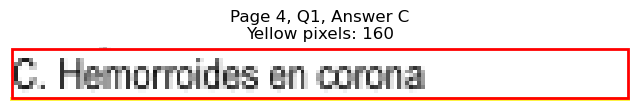

Page 4, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=390.2, y1=139.9
Page 4, Q1, D: Yellow pixels: 1388
Page 4, Q1, D: Total non-white pixels: 1638
Page 4, Q1, D: Yellow percentage: 84.7%


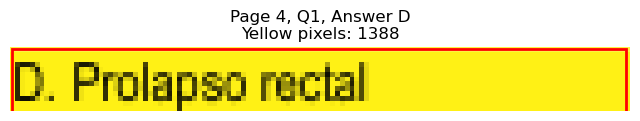


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)
Page 4, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=110.9, y1=203.0
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 366
Page 4, Q2, A: Yellow percentage: 0.0%


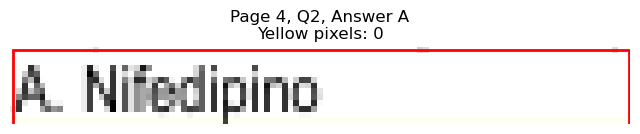

Page 4, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=158.5, y1=215.6
Page 4, Q2, B: Yellow pixels: 1588
Page 4, Q2, B: Total non-white pixels: 2142
Page 4, Q2, B: Yellow percentage: 74.1%


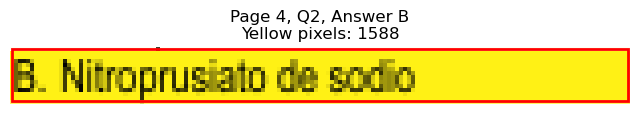

Page 4, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=366.7, y1=203.0
Page 4, Q2, C: Yellow pixels: 0
Page 4, Q2, C: Total non-white pixels: 230
Page 4, Q2, C: Yellow percentage: 0.0%


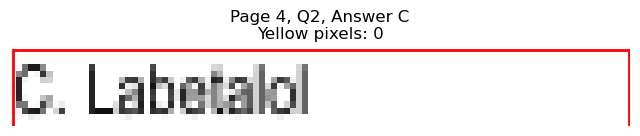

Page 4, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=382.7, y1=215.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 345
Page 4, Q2, D: Yellow percentage: 0.0%


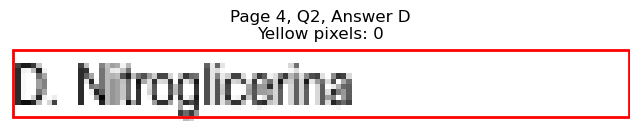


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)
Page 4, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=268.4, y1=278.7
Page 4, Q3, A: Yellow pixels: 2131
Page 4, Q3, A: Total non-white pixels: 2956
Page 4, Q3, A: Yellow percentage: 72.1%


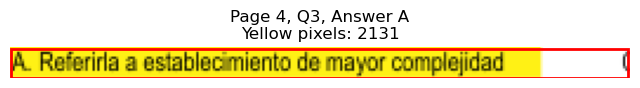

Page 4, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=162.1, y1=291.4
Page 4, Q3, B: Yellow pixels: 156
Page 4, Q3, B: Total non-white pixels: 637
Page 4, Q3, B: Yellow percentage: 24.5%


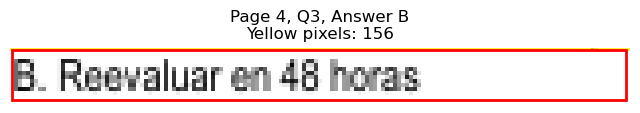

Page 4, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=428.8, y1=278.7
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 577
Page 4, Q3, C: Yellow percentage: 0.0%


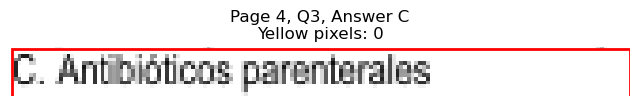

Page 4, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=494.6, y1=291.4
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 874
Page 4, Q3, D: Yellow percentage: 0.0%


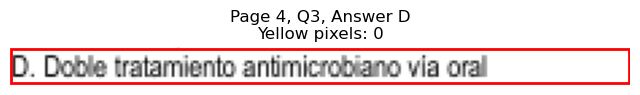


Page 4, Q3 - Selected Answer: A (based on yellow pixel count)
Page 4, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=168.6, y1=354.6
Page 4, Q4, A: Yellow pixels: 163
Page 4, Q4, A: Total non-white pixels: 670
Page 4, Q4, A: Yellow percentage: 24.3%


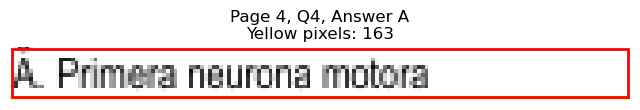

Page 4, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=173.2, y1=367.2
Page 4, Q4, B: Yellow pixels: 1734
Page 4, Q4, B: Total non-white pixels: 2352
Page 4, Q4, B: Yellow percentage: 73.7%


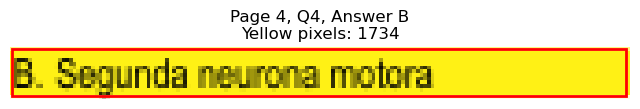

Page 4, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=427.9, y1=354.6
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 534
Page 4, Q4, C: Yellow percentage: 0.0%


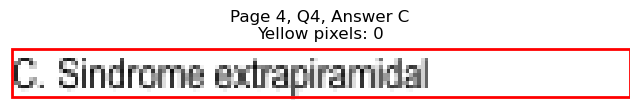

Page 4, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=379.1, y1=367.2
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 316
Page 4, Q4, D: Yellow percentage: 0.0%


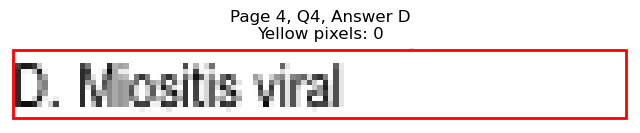


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)
Page 4, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=99.4, y1=430.3
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 196
Page 4, Q5, A: Yellow percentage: 0.0%


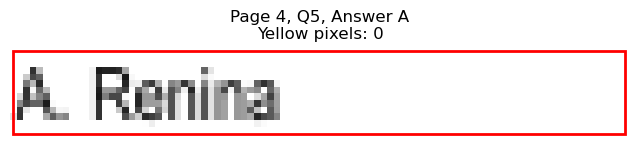

Page 4, Q5 - B: Detected box: x0=315.4, y0=379.7, x1=427.9, y1=392.4
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 539
Page 4, Q5, B: Yellow percentage: 0.0%


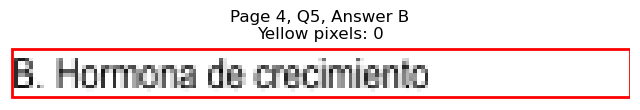

Page 4, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=449.5, y1=405.0
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 827
Page 4, Q5, C: Yellow percentage: 0.0%


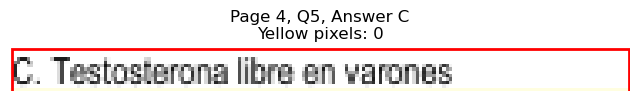

Page 4, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=489.6, y1=417.6
Page 4, Q5, D: Yellow pixels: 2272
Page 4, Q5, D: Total non-white pixels: 3150
Page 4, Q5, D: Yellow percentage: 72.1%


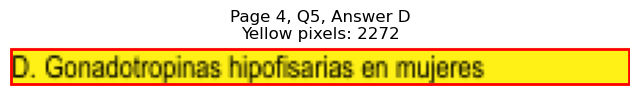


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)
Page 4, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=110.9, y1=468.1
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 284
Page 4, Q6, A: Yellow percentage: 0.0%


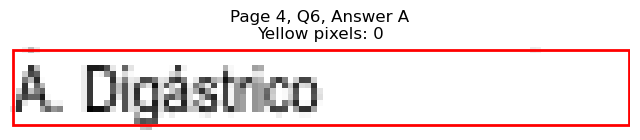

Page 4, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=124.0, y1=480.7
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 306
Page 4, Q6, B: Yellow percentage: 0.0%


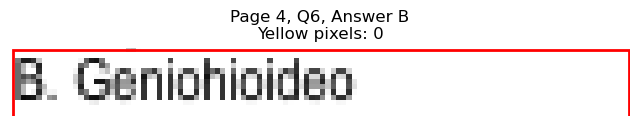

Page 4, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=375.7, y1=468.1
Page 4, Q6, C: Yellow pixels: 1190
Page 4, Q6, C: Total non-white pixels: 1554
Page 4, Q6, C: Yellow percentage: 76.6%


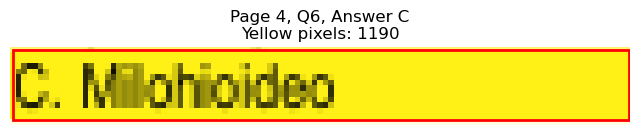

Page 4, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=381.2, y1=480.7
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 436
Page 4, Q6, D: Yellow percentage: 0.0%


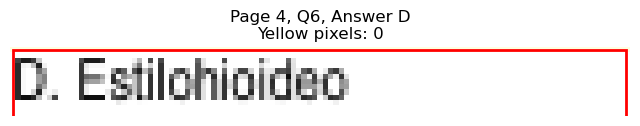


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)
Page 4, Q7 - A: Detected box: x0=56.6, y0=518.6, x1=163.1, y1=531.2
Page 4, Q7, A: Yellow pixels: 1659
Page 4, Q7, A: Total non-white pixels: 2212
Page 4, Q7, A: Yellow percentage: 75.0%


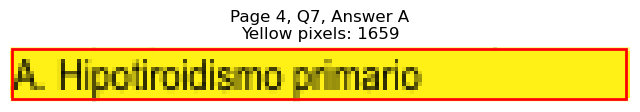

Page 4, Q7 - B: Detected box: x0=56.6, y0=531.2, x1=162.6, y1=543.8
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 683
Page 4, Q7, B: Yellow percentage: 0.0%


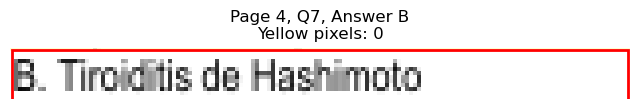

Page 4, Q7 - C: Detected box: x0=315.4, y0=518.6, x1=434.3, y1=531.2
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 616
Page 4, Q7, C: Yellow percentage: 0.0%


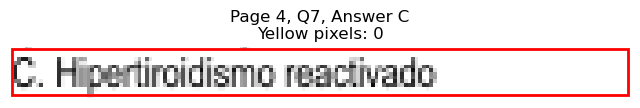

Page 4, Q7 - D: Detected box: x0=315.4, y0=531.2, x1=433.9, y1=543.8
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 608
Page 4, Q7, D: Yellow percentage: 0.0%


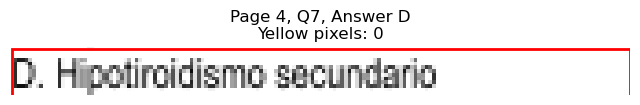


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)
Page 4, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=144.5, y1=606.9
Page 4, Q8, A: Yellow pixels: 1505
Page 4, Q8, A: Total non-white pixels: 1807
Page 4, Q8, A: Yellow percentage: 83.3%


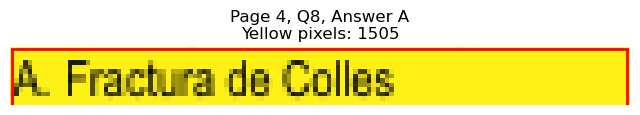

Page 4, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=139.1, y1=619.5
Page 4, Q8, B: Yellow pixels: 134
Page 4, Q8, B: Total non-white pixels: 502
Page 4, Q8, B: Yellow percentage: 26.7%


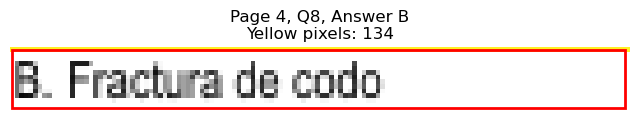

Page 4, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=401.3, y1=606.9
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 377
Page 4, Q8, C: Yellow percentage: 0.0%


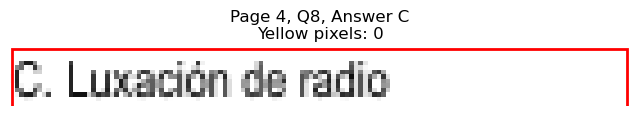

Page 4, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=432.4, y1=619.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 564
Page 4, Q8, D: Yellow percentage: 0.0%


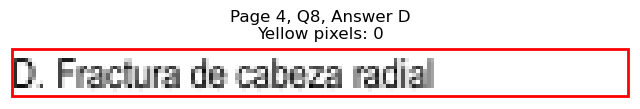


Page 4, Q8 - Selected Answer: A (based on yellow pixel count)
Page 4, Q9 - A: Detected box: x0=56.6, y0=682.6, x1=116.4, y1=695.3
Page 4, Q9, A: Yellow pixels: 1110
Page 4, Q9, A: Total non-white pixels: 1554
Page 4, Q9, A: Yellow percentage: 71.4%


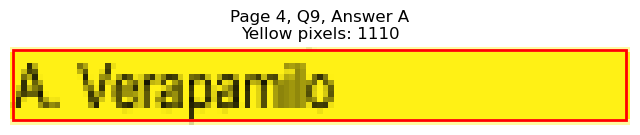

Page 4, Q9 - B: Detected box: x0=56.6, y0=695.4, x1=121.5, y1=708.0
Page 4, Q9, B: Yellow pixels: 1
Page 4, Q9, B: Total non-white pixels: 434
Page 4, Q9, B: Yellow percentage: 0.2%


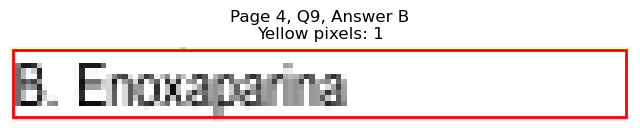

Page 4, Q9 - C: Detected box: x0=315.4, y0=682.6, x1=369.2, y1=695.3
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 215
Page 4, Q9, C: Yellow percentage: 0.0%


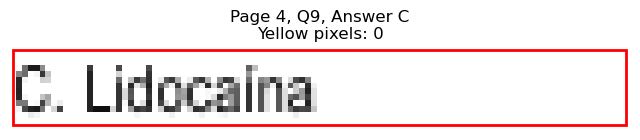

Page 4, Q9 - D: Detected box: x0=315.4, y0=695.4, x1=372.7, y1=708.0
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 259
Page 4, Q9, D: Yellow percentage: 0.0%


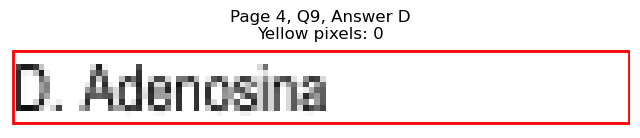


Page 4, Q9 - Selected Answer: A (based on yellow pixel count)
Page 4, Q10 - A: Detected box: x0=56.6, y0=745.8, x1=123.5, y1=758.4
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 317
Page 4, Q10, A: Yellow percentage: 0.0%


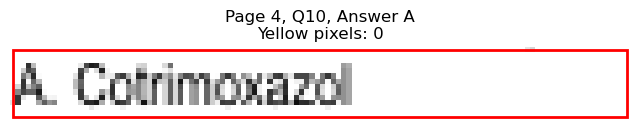

Page 4, Q10 - B: Detected box: x0=56.6, y0=758.5, x1=116.4, y1=771.1
Page 4, Q10, B: Yellow pixels: 1198
Page 4, Q10, B: Total non-white pixels: 1554
Page 4, Q10, B: Yellow percentage: 77.1%


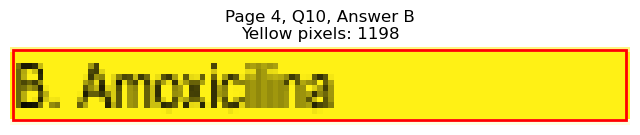

Page 4, Q10 - C: Detected box: x0=315.4, y0=745.8, x1=380.2, y1=758.4
Page 4, Q10, C: Yellow pixels: 0
Page 4, Q10, C: Total non-white pixels: 311
Page 4, Q10, C: Yellow percentage: 0.0%


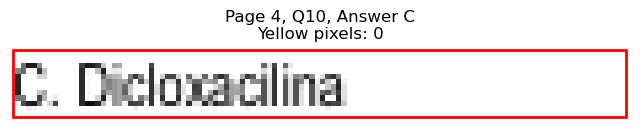

Page 4, Q10 - D: Detected box: x0=315.4, y0=758.5, x1=373.7, y1=771.1
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 277
Page 4, Q10, D: Yellow percentage: 0.0%


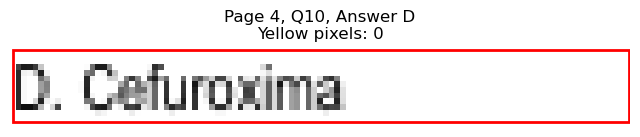


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)

Page 5: Found 9 questions
Page 5, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=116.9, y1=114.7
Page 5, Q1, A: Yellow pixels: 1259
Page 5, Q1, A: Total non-white pixels: 1443
Page 5, Q1, A: Yellow percentage: 87.2%


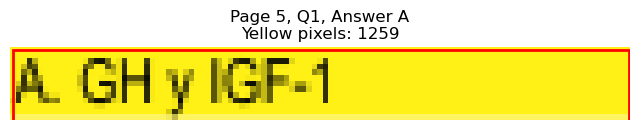

Page 5, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=111.9, y1=127.3
Page 5, Q1, B: Yellow pixels: 105
Page 5, Q1, B: Total non-white pixels: 346
Page 5, Q1, B: Yellow percentage: 30.3%


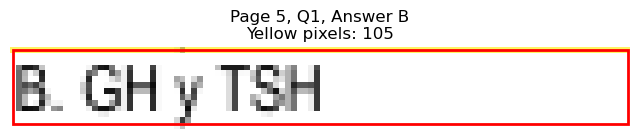

Page 5, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=348.1, y1=114.7
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 133
Page 5, Q1, C: Yellow percentage: 0.0%


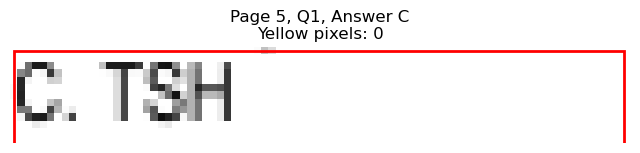

Page 5, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=362.1, y1=127.3
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 211
Page 5, Q1, D: Yellow percentage: 0.0%


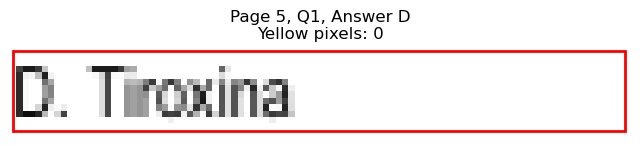


Page 5, Q1 - Selected Answer: A (based on yellow pixel count)
Page 5, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=75.9, y1=177.8
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 67
Page 5, Q2, A: Yellow percentage: 0.0%


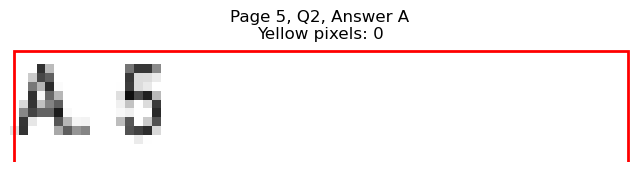

Page 5, Q2 - B: Detected box: x0=56.6, y0=720.6, x1=75.9, y1=733.2
Page 5, Q2, B: Yellow pixels: 856
Page 5, Q2, B: Total non-white pixels: 980
Page 5, Q2, B: Yellow percentage: 87.3%


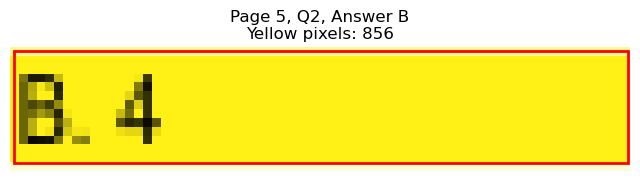

Page 5, Q2 - C: Detected box: x0=315.4, y0=708.0, x1=335.1, y1=720.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 66
Page 5, Q2, C: Yellow percentage: 0.0%


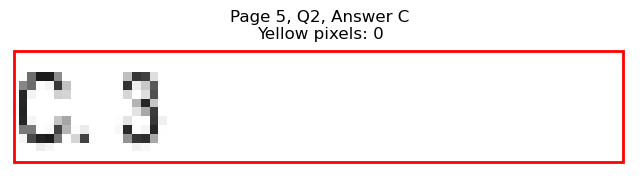

Page 5, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=335.1, y1=190.4
Page 5, Q2, D: Yellow pixels: 71
Page 5, Q2, D: Total non-white pixels: 148
Page 5, Q2, D: Yellow percentage: 48.0%


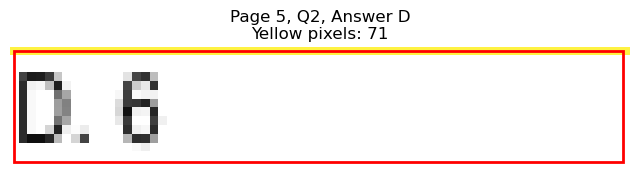


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)
Page 5, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=159.6, y1=266.1
Page 5, Q3, A: Yellow pixels: 154
Page 5, Q3, A: Total non-white pixels: 653
Page 5, Q3, A: Yellow percentage: 23.6%


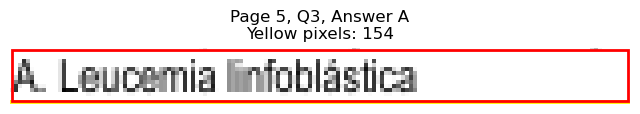

Page 5, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=185.2, y1=278.7
Page 5, Q3, B: Yellow pixels: 1864
Page 5, Q3, B: Total non-white pixels: 2340
Page 5, Q3, B: Yellow percentage: 79.7%


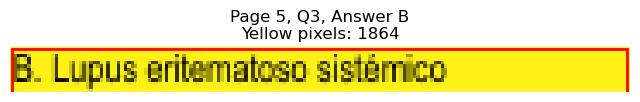

Page 5, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=424.4, y1=266.1
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 560
Page 5, Q3, C: Yellow percentage: 0.0%


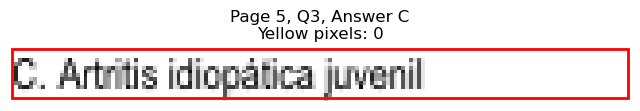

Page 5, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=406.3, y1=278.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 449
Page 5, Q3, D: Yellow percentage: 0.0%


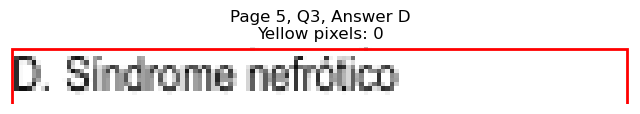


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)
Page 5, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=101.4, y1=329.2
Page 5, Q4, A: Yellow pixels: 96
Page 5, Q4, A: Total non-white pixels: 308
Page 5, Q4, A: Yellow percentage: 31.2%


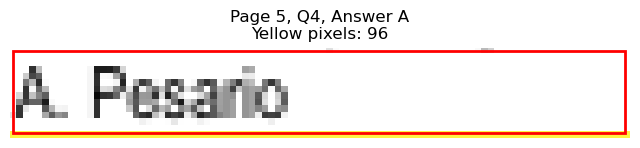

Page 5, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=122.4, y1=341.8
Page 5, Q4, B: Yellow pixels: 1283
Page 5, Q4, B: Total non-white pixels: 1521
Page 5, Q4, B: Yellow percentage: 84.4%


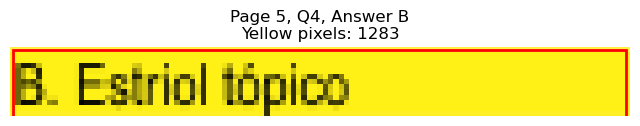

Page 5, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=406.3, y1=329.2
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 441
Page 5, Q4, C: Yellow percentage: 0.0%


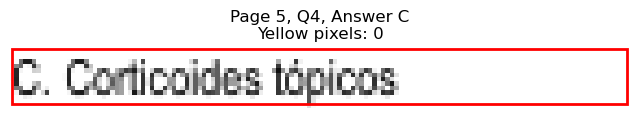

Page 5, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=410.3, y1=341.8
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 497
Page 5, Q4, D: Yellow percentage: 0.0%


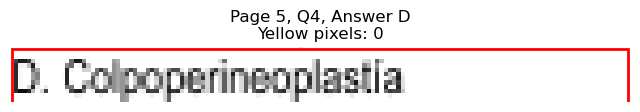


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)
Page 5, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=151.6, y1=405.0
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 588
Page 5, Q5, A: Yellow percentage: 0.0%


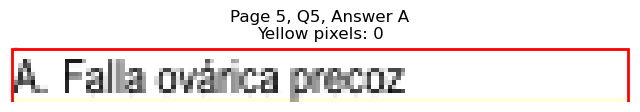

Page 5, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=128.4, y1=417.6
Page 5, Q5, B: Yellow pixels: 1323
Page 5, Q5, B: Total non-white pixels: 1722
Page 5, Q5, B: Yellow percentage: 76.8%


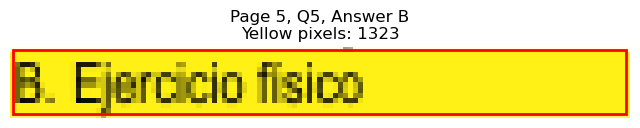

Page 5, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=387.2, y1=405.0
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 365
Page 5, Q5, C: Yellow percentage: 0.0%


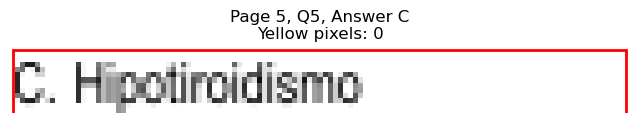

Page 5, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=456.4, y1=417.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 698
Page 5, Q5, D: Yellow percentage: 0.0%


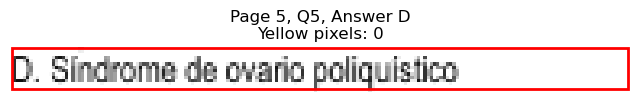


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)
Page 5, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=140.1, y1=480.7
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 383
Page 5, Q6, A: Yellow percentage: 0.0%


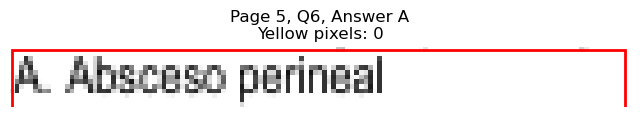

Page 5, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=132.5, y1=493.4
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 366
Page 5, Q6, B: Yellow percentage: 0.0%


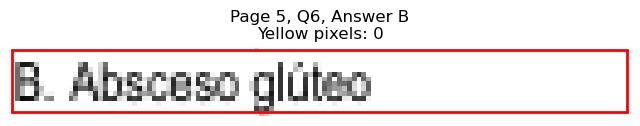

Page 5, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=422.3, y1=480.7
Page 5, Q6, C: Yellow pixels: 0
Page 5, Q6, C: Total non-white pixels: 526
Page 5, Q6, C: Yellow percentage: 0.0%


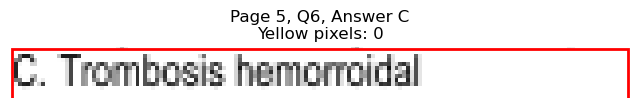

Page 5, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=417.8, y1=493.4
Page 5, Q6, D: Yellow pixels: 1442
Page 5, Q6, D: Total non-white pixels: 2142
Page 5, Q6, D: Yellow percentage: 67.3%


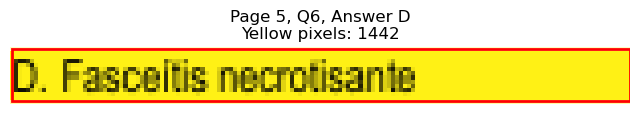


Page 5, Q6 - Selected Answer: D (based on yellow pixel count)
Page 5, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=130.5, y1=556.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 340
Page 5, Q7, A: Yellow percentage: 0.0%


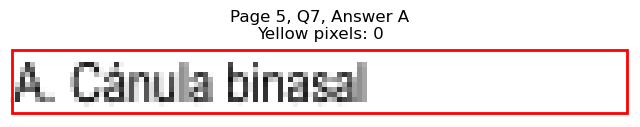

Page 5, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=160.6, y1=569.1
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 508
Page 5, Q7, B: Yellow percentage: 0.0%


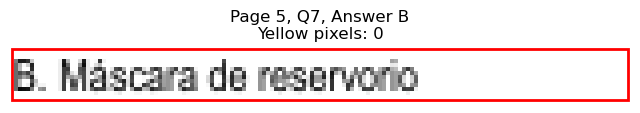

Page 5, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=407.3, y1=556.4
Page 5, Q7, C: Yellow pixels: 0
Page 5, Q7, C: Total non-white pixels: 434
Page 5, Q7, C: Yellow percentage: 0.0%


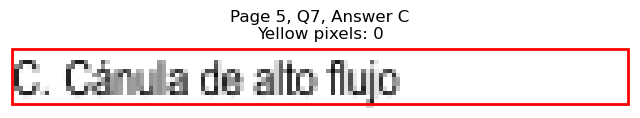

Page 5, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=450.4, y1=569.1
Page 5, Q7, D: Yellow pixels: 1918
Page 5, Q7, D: Total non-white pixels: 2604
Page 5, Q7, D: Yellow percentage: 73.7%


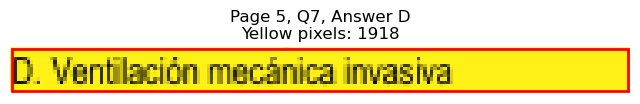


Page 5, Q7 - Selected Answer: D (based on yellow pixel count)
Page 5, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=169.6, y1=632.3
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 529
Page 5, Q8, A: Yellow percentage: 0.0%


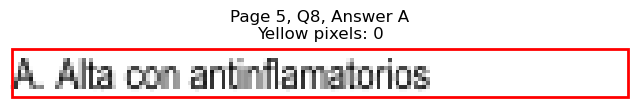

Page 5, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=242.3, y1=644.9
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 917
Page 5, Q8, B: Yellow percentage: 0.0%


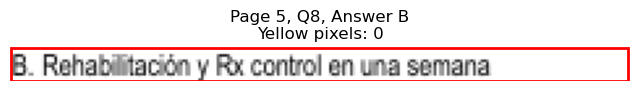

Page 5, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=507.6, y1=632.3
Page 5, Q8, C: Yellow pixels: 1976
Page 5, Q8, C: Total non-white pixels: 3164
Page 5, Q8, C: Yellow percentage: 62.5%


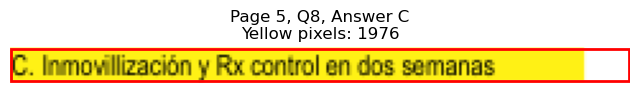

Page 5, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=434.9, y1=644.9
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 753
Page 5, Q8, D: Yellow percentage: 0.0%


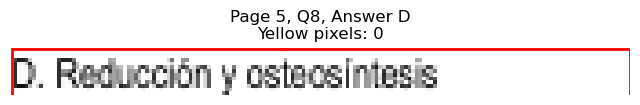


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)
Page 5, Q9 - A: Detected box: x0=56.6, y0=708.0, x1=75.9, y1=720.6
Page 5, Q9, A: Yellow pixels: 70
Page 5, Q9, A: Total non-white pixels: 135
Page 5, Q9, A: Yellow percentage: 51.9%


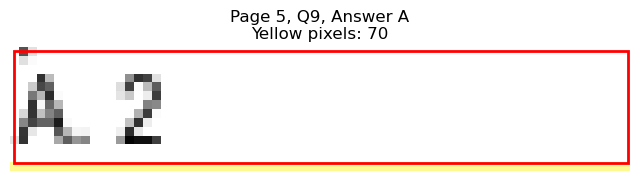

Page 5, Q9 - B: Detected box: x0=56.6, y0=720.6, x1=75.9, y1=733.2
Page 5, Q9, B: Yellow pixels: 856
Page 5, Q9, B: Total non-white pixels: 980
Page 5, Q9, B: Yellow percentage: 87.3%


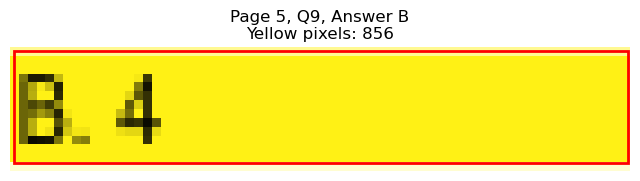

Page 5, Q9 - C: Detected box: x0=315.4, y0=708.0, x1=335.1, y1=720.6
Page 5, Q9, C: Yellow pixels: 0
Page 5, Q9, C: Total non-white pixels: 66
Page 5, Q9, C: Yellow percentage: 0.0%


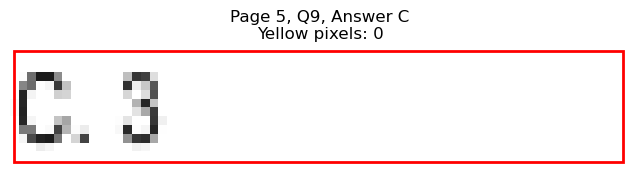

Page 5, Q9 - D: Detected box: x0=315.4, y0=720.6, x1=335.1, y1=733.2
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 71
Page 5, Q9, D: Yellow percentage: 0.0%


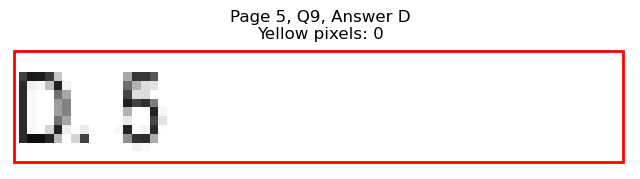


Page 5, Q9 - Selected Answer: B (based on yellow pixel count)

Page 6: Found 10 questions
Page 6, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=147.1, y1=127.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 434
Page 6, Q1, A: Yellow percentage: 0.0%


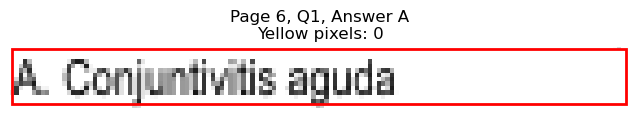

Page 6, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=150.0, y1=139.9
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 455
Page 6, Q1, B: Yellow percentage: 0.0%


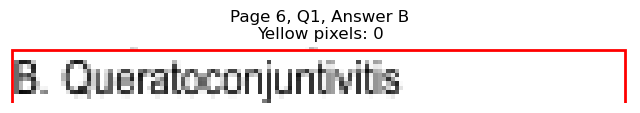

Page 6, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=398.9, y1=127.3
Page 6, Q1, C: Yellow pixels: 134
Page 6, Q1, C: Total non-white pixels: 521
Page 6, Q1, C: Yellow percentage: 25.7%


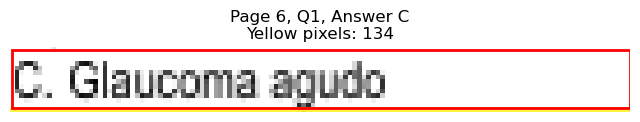

Page 6, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=396.8, y1=139.9
Page 6, Q1, D: Yellow pixels: 1389
Page 6, Q1, D: Total non-white pixels: 1716
Page 6, Q1, D: Yellow percentage: 80.9%


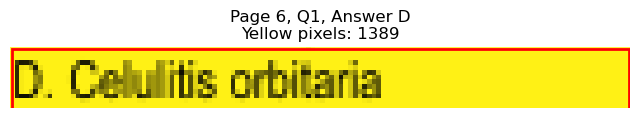


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)
Page 6, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=167.1, y1=203.0
Page 6, Q2, A: Yellow pixels: 1650
Page 6, Q2, A: Total non-white pixels: 2106
Page 6, Q2, A: Yellow percentage: 78.3%


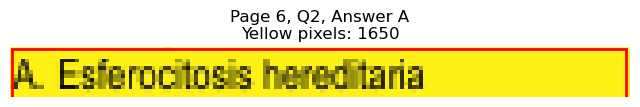

Page 6, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=217.7, y1=215.6
Page 6, Q2, B: Yellow pixels: 212
Page 6, Q2, B: Total non-white pixels: 991
Page 6, Q2, B: Yellow percentage: 21.4%


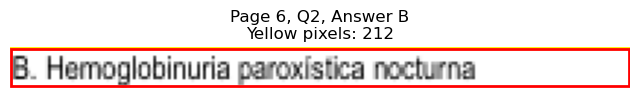

Page 6, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=396.3, y1=203.0
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 392
Page 6, Q2, C: Yellow percentage: 0.0%


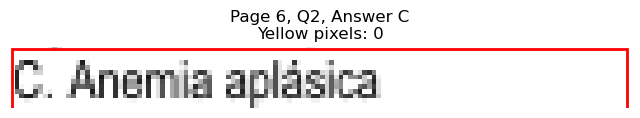

Page 6, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=423.3, y1=215.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 553
Page 6, Q2, D: Yellow percentage: 0.0%


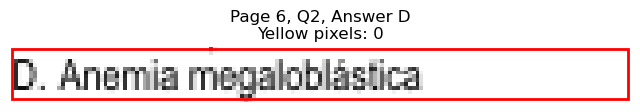


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)
Page 6, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=149.1, y1=266.1
Page 6, Q3, A: Yellow pixels: 0
Page 6, Q3, A: Total non-white pixels: 425
Page 6, Q3, A: Yellow percentage: 0.0%


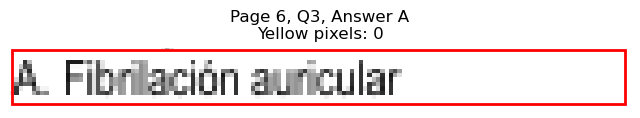

Page 6, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=133.5, y1=278.7
Page 6, Q3, B: Yellow pixels: 0
Page 6, Q3, B: Total non-white pixels: 353
Page 6, Q3, B: Yellow percentage: 0.0%


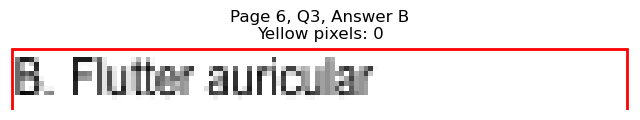

Page 6, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=413.8, y1=266.1
Page 6, Q3, C: Yellow pixels: 149
Page 6, Q3, C: Total non-white pixels: 648
Page 6, Q3, C: Yellow percentage: 23.0%


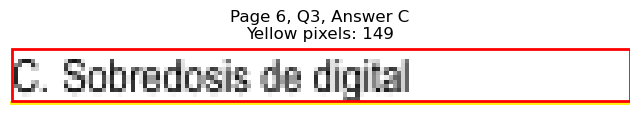

Page 6, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=471.5, y1=278.7
Page 6, Q3, D: Yellow pixels: 2059
Page 6, Q3, D: Total non-white pixels: 2691
Page 6, Q3, D: Yellow percentage: 76.5%


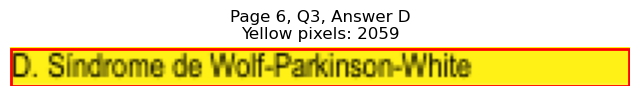


Page 6, Q3 - Selected Answer: D (based on yellow pixel count)
Page 6, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=123.5, y1=341.8
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 333
Page 6, Q4, A: Yellow percentage: 0.0%


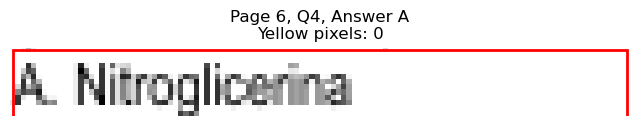

Page 6, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=107.4, y1=354.6
Page 6, Q4, B: Yellow pixels: 1127
Page 6, Q4, B: Total non-white pixels: 1428
Page 6, Q4, B: Yellow percentage: 78.9%


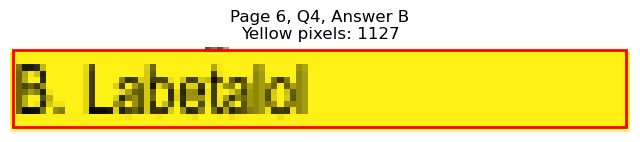

Page 6, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=362.1, y1=341.8
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 212
Page 6, Q4, C: Yellow percentage: 0.0%


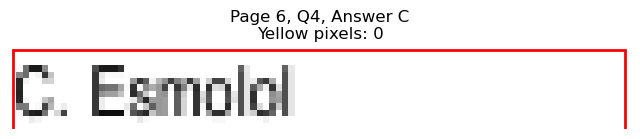

Page 6, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=417.8, y1=354.6
Page 6, Q4, D: Yellow pixels: 0
Page 6, Q4, D: Total non-white pixels: 495
Page 6, Q4, D: Yellow percentage: 0.0%


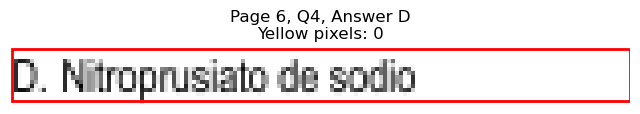


Page 6, Q4 - Selected Answer: B (based on yellow pixel count)
Page 6, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=113.9, y1=392.4
Page 6, Q5, A: Yellow pixels: 108
Page 6, Q5, A: Total non-white pixels: 376
Page 6, Q5, A: Yellow percentage: 28.7%


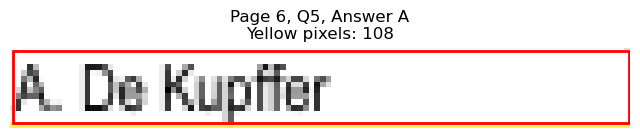

Page 6, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=110.9, y1=405.0
Page 6, Q5, B: Yellow pixels: 1164
Page 6, Q5, B: Total non-white pixels: 1365
Page 6, Q5, B: Yellow percentage: 85.3%


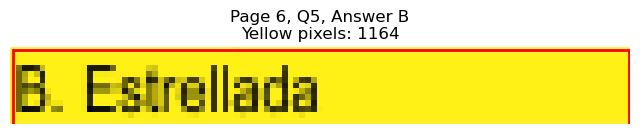

Page 6, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=373.1, y1=392.4
Page 6, Q5, C: Yellow pixels: 0
Page 6, Q5, C: Total non-white pixels: 277
Page 6, Q5, C: Yellow percentage: 0.0%


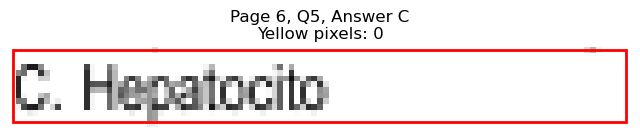

Page 6, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=412.3, y1=405.0
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 499
Page 6, Q5, D: Yellow percentage: 0.0%


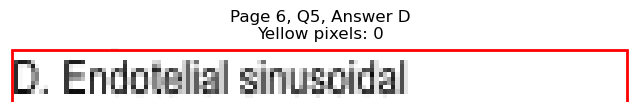


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)
Page 6, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=263.0, y1=468.1
Page 6, Q6, A: Yellow pixels: 2160
Page 6, Q6, A: Total non-white pixels: 3164
Page 6, Q6, A: Yellow percentage: 68.3%


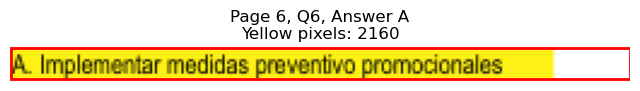

Page 6, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=222.4, y1=480.7
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 1063
Page 6, Q6, B: Yellow percentage: 0.0%


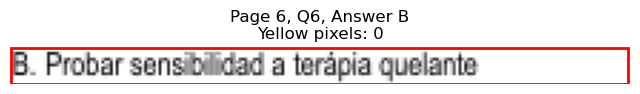

Page 6, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=459.5, y1=468.1
Page 6, Q6, C: Yellow pixels: 0
Page 6, Q6, C: Total non-white pixels: 725
Page 6, Q6, C: Yellow percentage: 0.0%


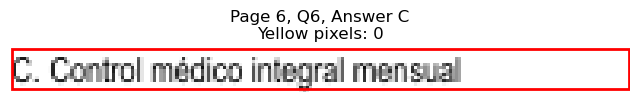

Page 6, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=519.7, y1=480.7
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 1021
Page 6, Q6, D: Yellow percentage: 0.0%


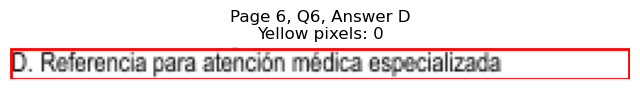


Page 6, Q6 - Selected Answer: A (based on yellow pixel count)
Page 6, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=133.5, y1=543.8
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 354
Page 6, Q7, A: Yellow percentage: 0.0%


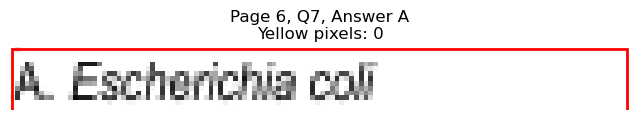

Page 6, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=159.0, y1=556.4
Page 6, Q7, B: Yellow pixels: 0
Page 6, Q7, B: Total non-white pixels: 494
Page 6, Q7, B: Yellow percentage: 0.0%


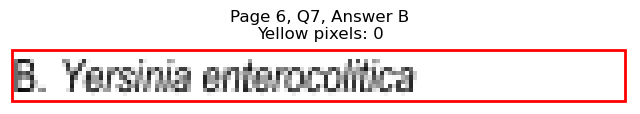

Page 6, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=411.8, y1=543.8
Page 6, Q7, C: Yellow pixels: 1530
Page 6, Q7, C: Total non-white pixels: 1911
Page 6, Q7, C: Yellow percentage: 80.1%


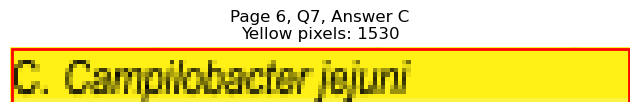

Page 6, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=376.1, y1=556.4
Page 6, Q7, D: Yellow pixels: 106
Page 6, Q7, D: Total non-white pixels: 394
Page 6, Q7, D: Yellow percentage: 26.9%


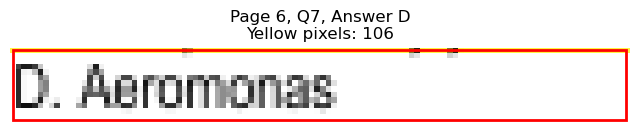


Page 6, Q7 - Selected Answer: C (based on yellow pixel count)
Page 6, Q8 - A: Detected box: x0=56.6, y0=594.3, x1=172.1, y1=606.9
Page 6, Q8, A: Yellow pixels: 1751
Page 6, Q8, A: Total non-white pixels: 2171
Page 6, Q8, A: Yellow percentage: 80.7%


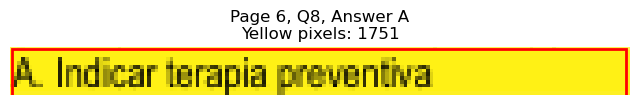

Page 6, Q8 - B: Detected box: x0=56.6, y0=606.9, x1=184.2, y1=619.5
Page 6, Q8, B: Yellow pixels: 176
Page 6, Q8, B: Total non-white pixels: 796
Page 6, Q8, B: Yellow percentage: 22.1%


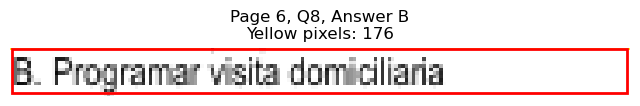

Page 6, Q8 - C: Detected box: x0=315.4, y0=594.3, x1=410.3, y1=606.9
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 444
Page 6, Q8, C: Yellow percentage: 0.0%


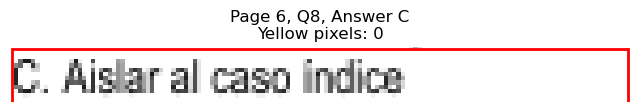

Page 6, Q8 - D: Detected box: x0=315.4, y0=606.9, x1=416.8, y1=619.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 476
Page 6, Q8, D: Yellow percentage: 0.0%


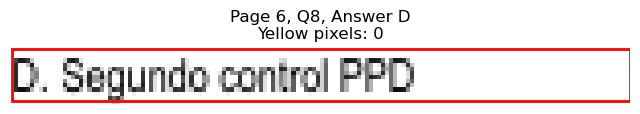


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)
Page 6, Q9 - A: Detected box: x0=56.6, y0=670.0, x1=204.8, y1=682.7
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 915
Page 6, Q9, A: Yellow percentage: 0.0%


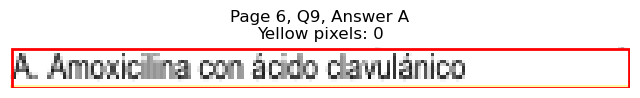

Page 6, Q9 - B: Detected box: x0=56.6, y0=682.6, x1=113.9, y1=695.3
Page 6, Q9, B: Yellow pixels: 1095
Page 6, Q9, B: Total non-white pixels: 1512
Page 6, Q9, B: Yellow percentage: 72.4%


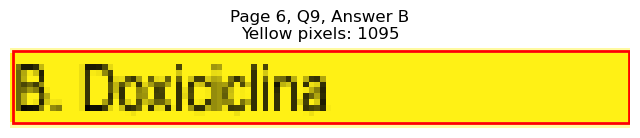

Page 6, Q9 - C: Detected box: x0=315.4, y0=670.0, x1=375.7, y1=682.7
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 280
Page 6, Q9, C: Yellow percentage: 0.0%


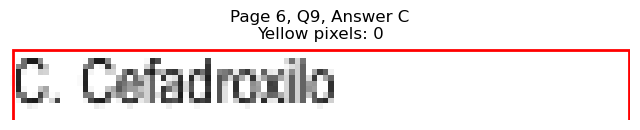

Page 6, Q9 - D: Detected box: x0=315.4, y0=682.6, x1=385.3, y1=695.3
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 314
Page 6, Q9, D: Yellow percentage: 0.0%


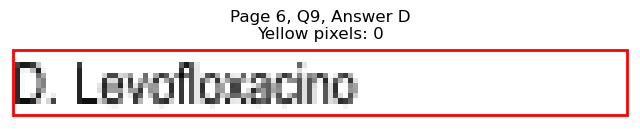


Page 6, Q9 - Selected Answer: B (based on yellow pixel count)
Page 6, Q10 - A: Detected box: x0=56.6, y0=720.6, x1=103.9, y1=733.2
Page 6, Q10, A: Yellow pixels: 98
Page 6, Q10, A: Total non-white pixels: 331
Page 6, Q10, A: Yellow percentage: 29.6%


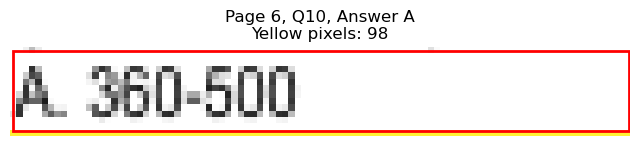

Page 6, Q10 - B: Detected box: x0=56.6, y0=733.2, x1=98.9, y1=745.8
Page 6, Q10, B: Yellow pixels: 1062
Page 6, Q10, B: Total non-white pixels: 1209
Page 6, Q10, B: Yellow percentage: 87.8%


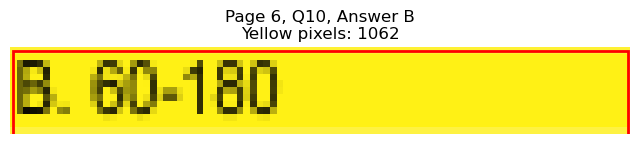

Page 6, Q10 - C: Detected box: x0=315.4, y0=720.6, x1=363.2, y1=733.2
Page 6, Q10, C: Yellow pixels: 0
Page 6, Q10, C: Total non-white pixels: 211
Page 6, Q10, C: Yellow percentage: 0.0%


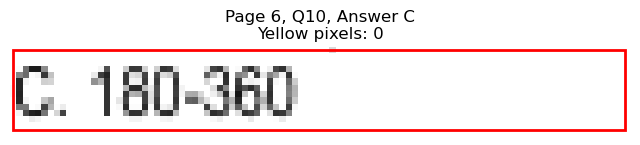

Page 6, Q10 - D: Detected box: x0=315.4, y0=733.2, x1=353.1, y1=745.8
Page 6, Q10, D: Yellow pixels: 0
Page 6, Q10, D: Total non-white pixels: 153
Page 6, Q10, D: Yellow percentage: 0.0%


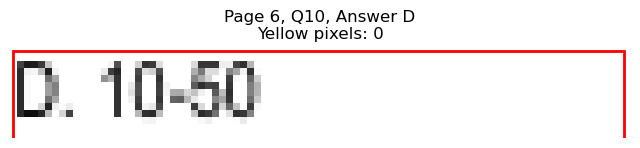


Page 6, Q10 - Selected Answer: B (based on yellow pixel count)

Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=177.1, y1=114.7
Page 7, Q1, A: Yellow pixels: 1797
Page 7, Q1, A: Total non-white pixels: 2236
Page 7, Q1, A: Yellow percentage: 80.4%


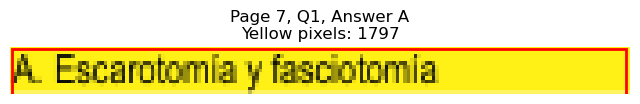

Page 7, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=249.4, y1=127.3
Page 7, Q1, B: Yellow pixels: 224
Page 7, Q1, B: Total non-white pixels: 1179
Page 7, Q1, B: Yellow percentage: 19.0%


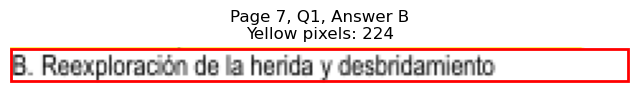

Page 7, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=415.3, y1=114.7
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 490
Page 7, Q1, C: Yellow percentage: 0.0%


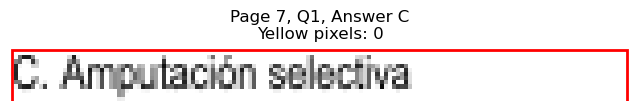

Page 7, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=422.3, y1=127.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 540
Page 7, Q1, D: Yellow percentage: 0.0%


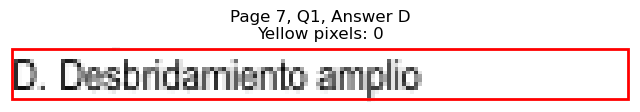


Page 7, Q1 - Selected Answer: A (based on yellow pixel count)
Page 7, Q2 - A: Detected box: x0=56.6, y0=165.1, x1=171.1, y1=177.8
Page 7, Q2, A: Yellow pixels: 1735
Page 7, Q2, A: Total non-white pixels: 2158
Page 7, Q2, A: Yellow percentage: 80.4%


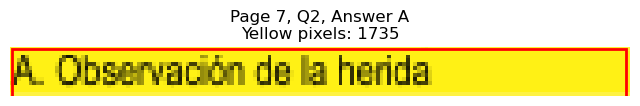

Page 7, Q2 - B: Detected box: x0=56.6, y0=177.7, x1=150.0, y1=190.4
Page 7, Q2, B: Yellow pixels: 145
Page 7, Q2, B: Total non-white pixels: 608
Page 7, Q2, B: Yellow percentage: 23.8%


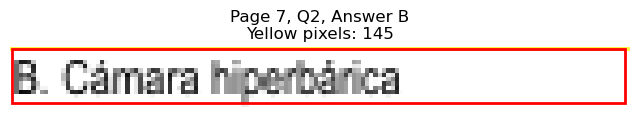

Page 7, Q2 - C: Detected box: x0=315.4, y0=165.1, x1=431.8, y1=177.8
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 568
Page 7, Q2, C: Yellow percentage: 0.0%


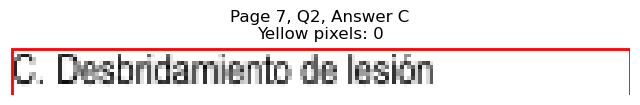

Page 7, Q2 - D: Detected box: x0=315.4, y0=177.7, x1=399.8, y1=190.4
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 412
Page 7, Q2, D: Yellow percentage: 0.0%


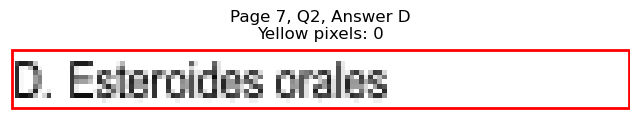


Page 7, Q2 - Selected Answer: A (based on yellow pixel count)
Page 7, Q3 - A: Detected box: x0=56.6, y0=228.2, x1=180.1, y1=240.9
Page 7, Q3, A: Yellow pixels: 1806
Page 7, Q3, A: Total non-white pixels: 2275
Page 7, Q3, A: Yellow percentage: 79.4%


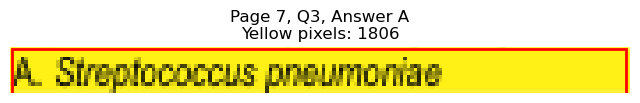

Page 7, Q3 - B: Detected box: x0=56.6, y0=240.8, x1=164.1, y1=253.5
Page 7, Q3, B: Yellow pixels: 156
Page 7, Q3, B: Total non-white pixels: 682
Page 7, Q3, B: Yellow percentage: 22.9%


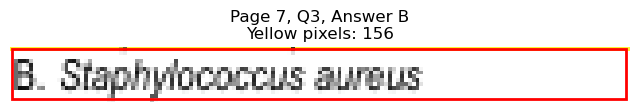

Page 7, Q3 - C: Detected box: x0=315.4, y0=228.2, x1=399.3, y1=240.9
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 412
Page 7, Q3, C: Yellow percentage: 0.0%


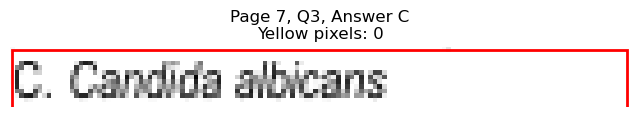

Page 7, Q3 - D: Detected box: x0=315.4, y0=240.8, x1=386.7, y1=253.5
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 333
Page 7, Q3, D: Yellow percentage: 0.0%


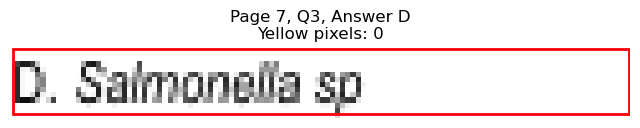


Page 7, Q3 - Selected Answer: A (based on yellow pixel count)
Page 7, Q4 - A: Detected box: x0=56.6, y0=291.4, x1=109.0, y1=304.0
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 206
Page 7, Q4, A: Yellow percentage: 0.0%


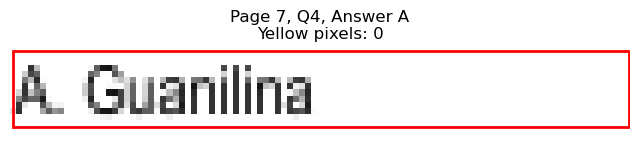

Page 7, Q4 - B: Detected box: x0=56.6, y0=304.0, x1=85.3, y1=316.6
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 110
Page 7, Q4, B: Yellow percentage: 0.0%


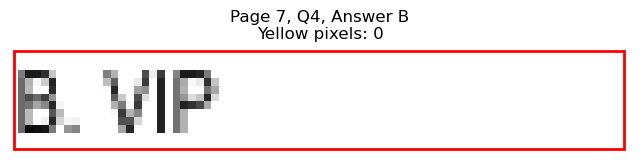

Page 7, Q4 - C: Detected box: x0=315.4, y0=291.4, x1=405.8, y1=304.0
Page 7, Q4, C: Yellow pixels: 1473
Page 7, Q4, C: Total non-white pixels: 1974
Page 7, Q4, C: Yellow percentage: 74.6%


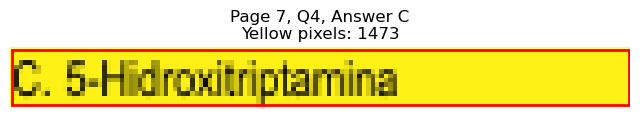

Page 7, Q4 - D: Detected box: x0=315.4, y0=304.0, x1=372.7, y1=316.6
Page 7, Q4, D: Yellow pixels: 106
Page 7, Q4, D: Total non-white pixels: 475
Page 7, Q4, D: Yellow percentage: 22.3%


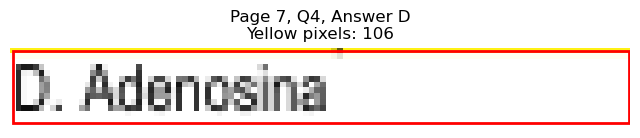


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)
Page 7, Q5 - A: Detected box: x0=56.6, y0=379.7, x1=129.5, y1=392.4
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 355
Page 7, Q5, A: Yellow percentage: 0.0%


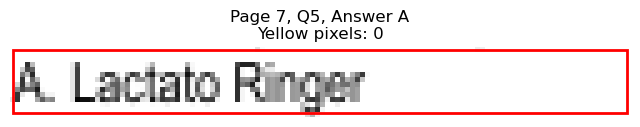

Page 7, Q5 - B: Detected box: x0=56.6, y0=392.3, x1=169.6, y1=405.0
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 524
Page 7, Q5, B: Yellow percentage: 0.0%


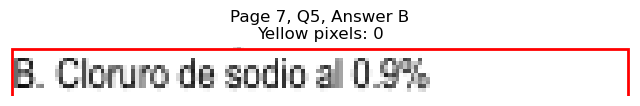

Page 7, Q5 - C: Detected box: x0=315.4, y0=379.7, x1=406.3, y1=392.4
Page 7, Q5, C: Yellow pixels: 1385
Page 7, Q5, C: Total non-white pixels: 1988
Page 7, Q5, C: Yellow percentage: 69.7%


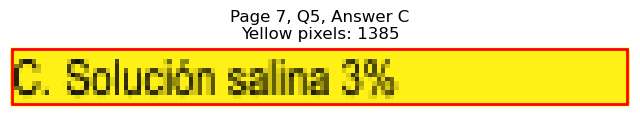

Page 7, Q5 - D: Detected box: x0=315.4, y0=392.3, x1=431.3, y1=405.0
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 715
Page 7, Q5, D: Yellow percentage: 0.0%


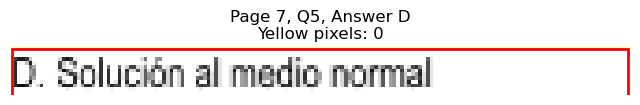


Page 7, Q5 - Selected Answer: C (based on yellow pixel count)
Page 7, Q6 - A: Detected box: x0=56.6, y0=455.5, x1=146.5, y1=468.1
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 388
Page 7, Q6, A: Yellow percentage: 0.0%


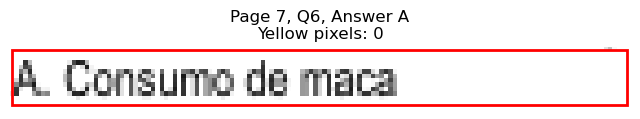

Page 7, Q6 - B: Detected box: x0=56.6, y0=468.1, x1=138.5, y1=480.7
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 385
Page 7, Q6, B: Yellow percentage: 0.0%


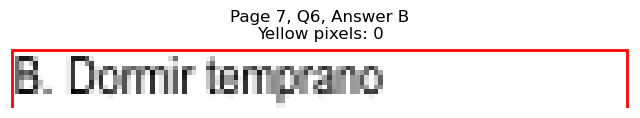

Page 7, Q6 - C: Detected box: x0=315.4, y0=455.5, x1=374.2, y1=468.1
Page 7, Q6, C: Yellow pixels: 110
Page 7, Q6, C: Total non-white pixels: 365
Page 7, Q6, C: Yellow percentage: 30.1%


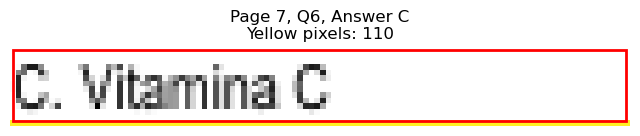

Page 7, Q6 - D: Detected box: x0=315.4, y0=468.1, x1=385.7, y1=480.7
Page 7, Q6, D: Yellow pixels: 1323
Page 7, Q6, D: Total non-white pixels: 1573
Page 7, Q6, D: Yellow percentage: 84.1%


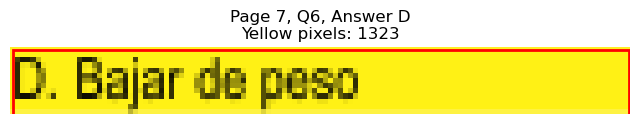


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)
Page 7, Q7 - A: Detected box: x0=56.6, y0=543.8, x1=88.3, y1=556.4
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 123
Page 7, Q7, A: Yellow percentage: 0.0%


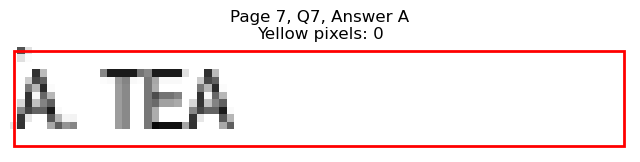

Page 7, Q7 - B: Detected box: x0=56.6, y0=556.5, x1=130.9, y1=569.1
Page 7, Q7, B: Yellow pixels: 1346
Page 7, Q7, B: Total non-white pixels: 1750
Page 7, Q7, B: Yellow percentage: 76.9%


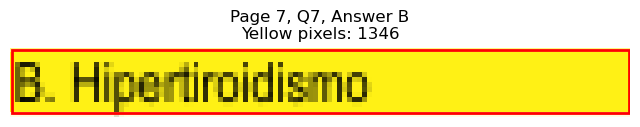

Page 7, Q7 - C: Detected box: x0=315.4, y0=543.8, x1=402.8, y1=556.4
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 420
Page 7, Q7, C: Yellow percentage: 0.0%


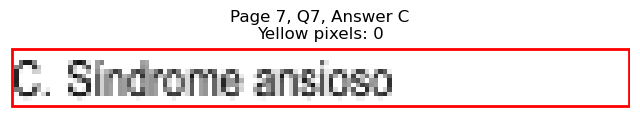

Page 7, Q7 - D: Detected box: x0=315.4, y0=556.5, x1=354.7, y1=569.1
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 166
Page 7, Q7, D: Yellow percentage: 0.0%


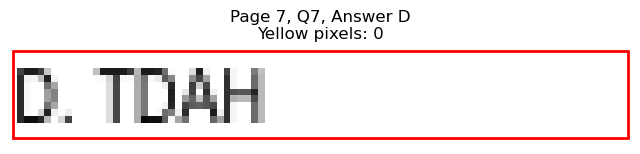


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)
Page 7, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=168.1, y1=632.3
Page 7, Q8, A: Yellow pixels: 1509
Page 7, Q8, A: Total non-white pixels: 2282
Page 7, Q8, A: Yellow percentage: 66.1%


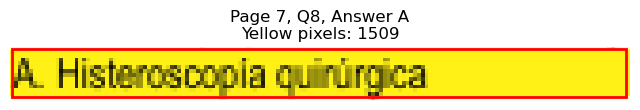

Page 7, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=183.1, y1=644.9
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 842
Page 7, Q8, B: Yellow percentage: 0.0%


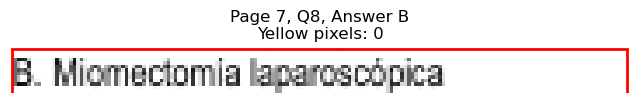

Page 7, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=414.3, y1=632.3
Page 7, Q8, C: Yellow pixels: 0
Page 7, Q8, C: Total non-white pixels: 482
Page 7, Q8, C: Yellow percentage: 0.0%


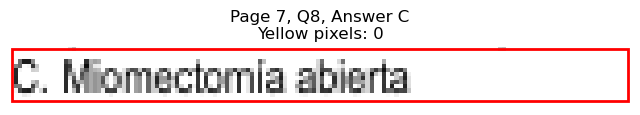

Page 7, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=408.3, y1=644.9
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 429
Page 7, Q8, D: Yellow percentage: 0.0%


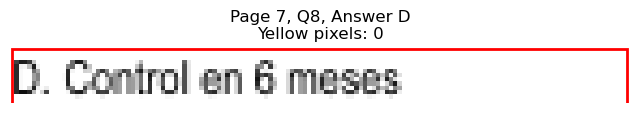


Page 7, Q8 - Selected Answer: A (based on yellow pixel count)
Page 7, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=178.1, y1=708.0
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 587
Page 7, Q9, A: Yellow percentage: 0.0%


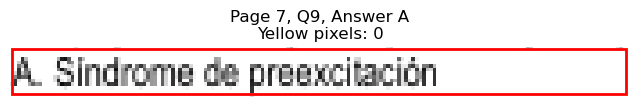

Page 7, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=133.5, y1=720.6
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 355
Page 7, Q9, B: Yellow percentage: 0.0%


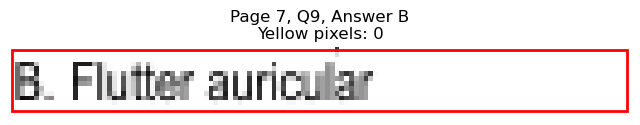

Page 7, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=470.0, y1=708.0
Page 7, Q9, C: Yellow pixels: 2093
Page 7, Q9, C: Total non-white pixels: 2680
Page 7, Q9, C: Yellow percentage: 78.1%


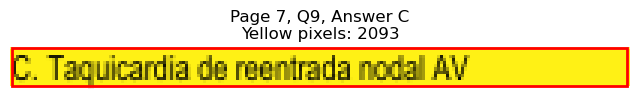

Page 7, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=405.8, y1=720.6
Page 7, Q9, D: Yellow pixels: 139
Page 7, Q9, D: Total non-white pixels: 611
Page 7, Q9, D: Yellow percentage: 22.7%


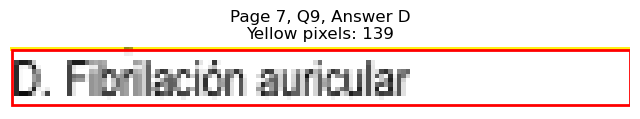


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)

Page 8: Found 9 questions
Page 8, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=115.5, y1=114.7
Page 8, Q1, A: Yellow pixels: 0
Page 8, Q1, A: Total non-white pixels: 392
Page 8, Q1, A: Yellow percentage: 0.0%


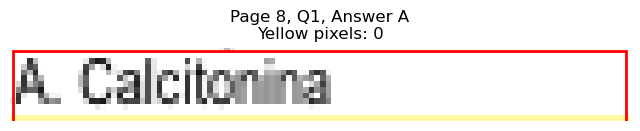

Page 8, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=121.0, y1=127.3
Page 8, Q1, B: Yellow pixels: 1134
Page 8, Q1, B: Total non-white pixels: 1610
Page 8, Q1, B: Yellow percentage: 70.4%


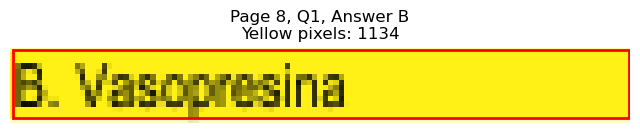

Page 8, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=392.2, y1=114.7
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 357
Page 8, Q1, C: Yellow percentage: 0.0%


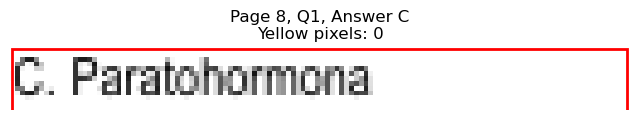

Page 8, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=358.6, y1=127.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 199
Page 8, Q1, D: Yellow percentage: 0.0%


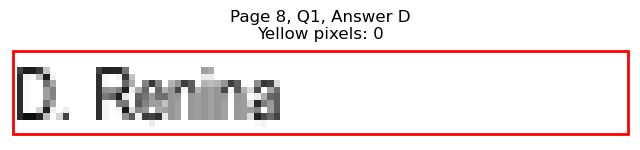


Page 8, Q1 - Selected Answer: B (based on yellow pixel count)
Page 8, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=80.9, y1=203.0
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 82
Page 8, Q2, A: Yellow percentage: 0.0%


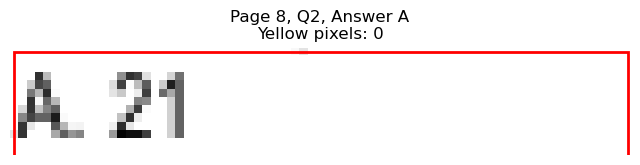

Page 8, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=80.9, y1=215.6
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 84
Page 8, Q2, B: Yellow percentage: 0.0%


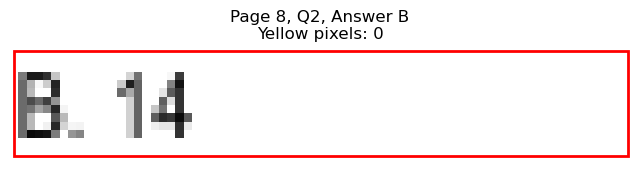

Page 8, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=335.1, y1=203.0
Page 8, Q2, C: Yellow pixels: 883
Page 8, Q2, C: Total non-white pixels: 923
Page 8, Q2, C: Yellow percentage: 95.7%


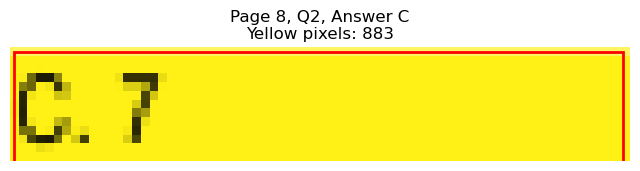

Page 8, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=335.1, y1=215.6
Page 8, Q2, D: Yellow pixels: 71
Page 8, Q2, D: Total non-white pixels: 141
Page 8, Q2, D: Yellow percentage: 50.4%


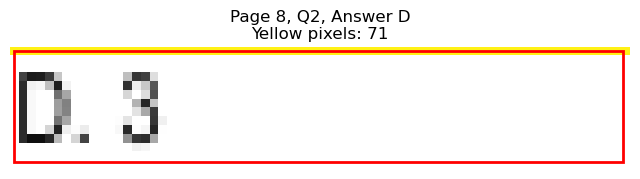


Page 8, Q2 - Selected Answer: C (based on yellow pixel count)
Page 8, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=195.3, y1=266.1
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 679
Page 8, Q3, A: Yellow percentage: 0.0%


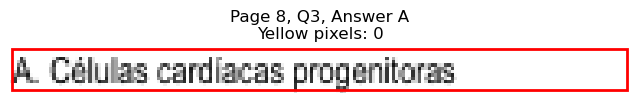

Page 8, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=178.1, y1=278.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 641
Page 8, Q3, B: Yellow percentage: 0.0%


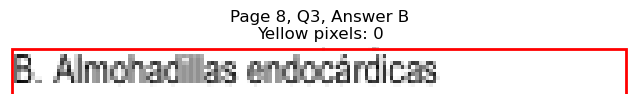

Page 8, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=436.9, y1=266.1
Page 8, Q3, C: Yellow pixels: 1778
Page 8, Q3, C: Total non-white pixels: 2408
Page 8, Q3, C: Yellow percentage: 73.8%


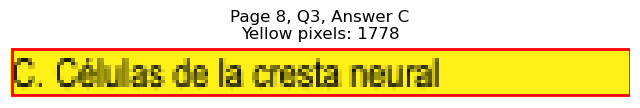

Page 8, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=473.0, y1=278.7
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 983
Page 8, Q3, D: Yellow percentage: 0.0%


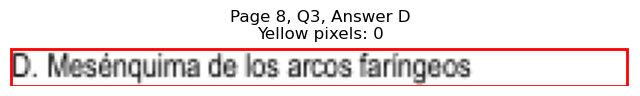


Page 8, Q3 - Selected Answer: C (based on yellow pixel count)
Page 8, Q4 - A: Detected box: x0=56.6, y0=329.2, x1=150.0, y1=341.8
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 443
Page 8, Q4, A: Yellow percentage: 0.0%


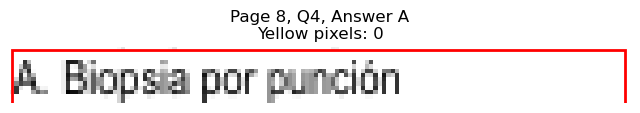

Page 8, Q4 - B: Detected box: x0=56.6, y0=341.9, x1=125.4, y1=354.6
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 347
Page 8, Q4, B: Yellow percentage: 0.0%


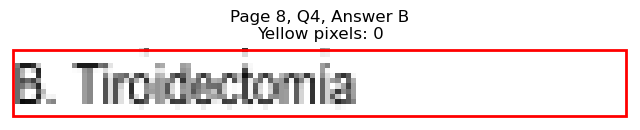

Page 8, Q4 - C: Detected box: x0=315.4, y0=329.2, x1=385.3, y1=341.8
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 330
Page 8, Q4, C: Yellow percentage: 0.0%


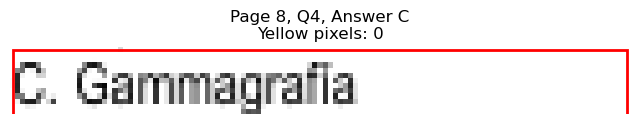

Page 8, Q4 - D: Detected box: x0=315.4, y0=341.9, x1=401.8, y1=354.6
Page 8, Q4, D: Yellow pixels: 1454
Page 8, Q4, D: Total non-white pixels: 1918
Page 8, Q4, D: Yellow percentage: 75.8%


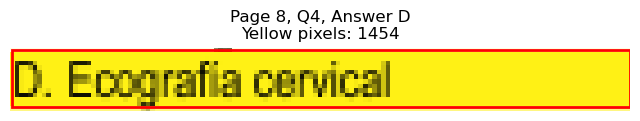


Page 8, Q4 - Selected Answer: D (based on yellow pixel count)
Page 8, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=115.0, y1=417.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 276
Page 8, Q5, A: Yellow percentage: 0.0%


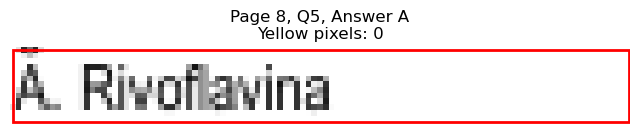

Page 8, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=100.9, y1=430.3
Page 8, Q5, B: Yellow pixels: 0
Page 8, Q5, B: Total non-white pixels: 201
Page 8, Q5, B: Yellow percentage: 0.0%


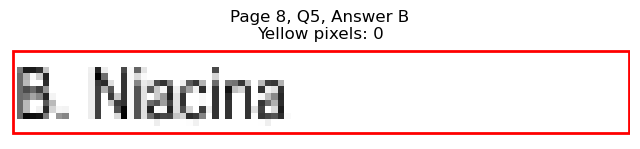

Page 8, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=362.1, y1=417.6
Page 8, Q5, C: Yellow pixels: 1123
Page 8, Q5, C: Total non-white pixels: 1372
Page 8, Q5, C: Yellow percentage: 81.9%


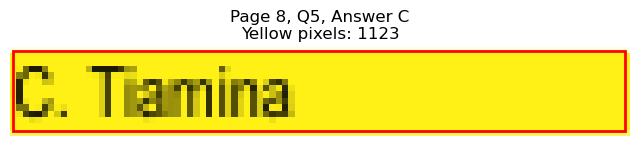

Page 8, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=399.8, y1=430.3
Page 8, Q5, D: Yellow pixels: 135
Page 8, Q5, D: Total non-white pixels: 555
Page 8, Q5, D: Yellow percentage: 24.3%


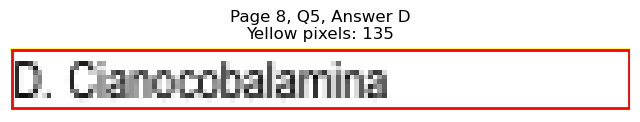


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)
Page 8, Q6 - A: Detected box: x0=56.6, y0=506.0, x1=75.9, y1=518.6
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 56
Page 8, Q6, A: Yellow percentage: 0.0%


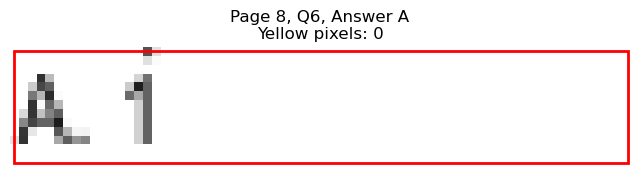

Page 8, Q6 - B: Detected box: x0=56.6, y0=518.6, x1=75.9, y1=531.2
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 66
Page 8, Q6, B: Yellow percentage: 0.0%


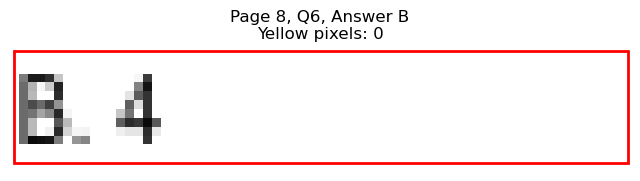

Page 8, Q6 - C: Detected box: x0=315.4, y0=506.0, x1=335.1, y1=518.6
Page 8, Q6, C: Yellow pixels: 877
Page 8, Q6, C: Total non-white pixels: 994
Page 8, Q6, C: Yellow percentage: 88.2%


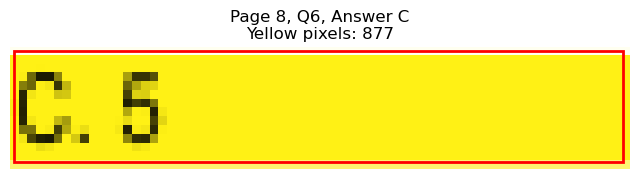

Page 8, Q6 - D: Detected box: x0=315.4, y0=518.6, x1=335.1, y1=531.2
Page 8, Q6, D: Yellow pixels: 71
Page 8, Q6, D: Total non-white pixels: 137
Page 8, Q6, D: Yellow percentage: 51.8%


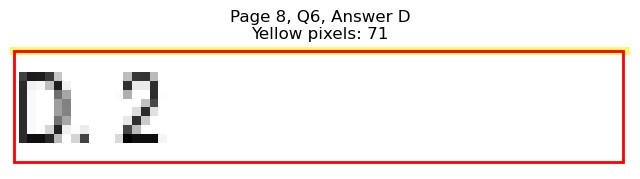


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)
Page 8, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=162.6, y1=581.7
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 542
Page 8, Q7, A: Yellow percentage: 0.0%


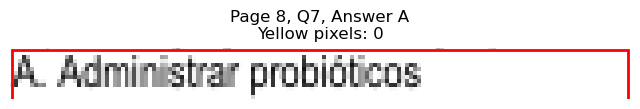

Page 8, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=115.9, y1=594.3
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 297
Page 8, Q7, B: Yellow percentage: 0.0%


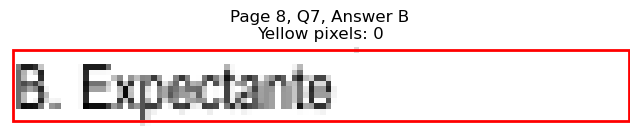

Page 8, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=525.1, y1=581.7
Page 8, Q7, C: Yellow pixels: 2134
Page 8, Q7, C: Total non-white pixels: 2938
Page 8, Q7, C: Yellow percentage: 72.6%


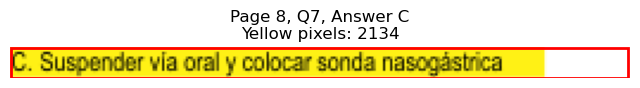

Page 8, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=517.2, y1=594.3
Page 8, Q7, D: Yellow pixels: 223
Page 8, Q7, D: Total non-white pixels: 1202
Page 8, Q7, D: Yellow percentage: 18.6%


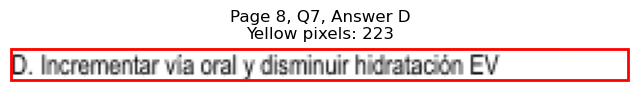


Page 8, Q7 - Selected Answer: C (based on yellow pixel count)
Page 8, Q8 - A: Detected box: x0=56.6, y0=632.2, x1=110.9, y1=644.9
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 248
Page 8, Q8, A: Yellow percentage: 0.0%


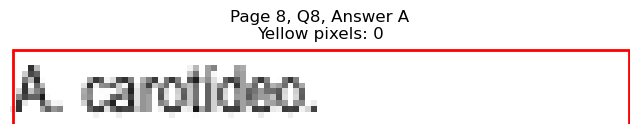

Page 8, Q8 - B: Detected box: x0=56.6, y0=644.8, x1=103.5, y1=657.5
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 193
Page 8, Q8, B: Yellow percentage: 0.0%


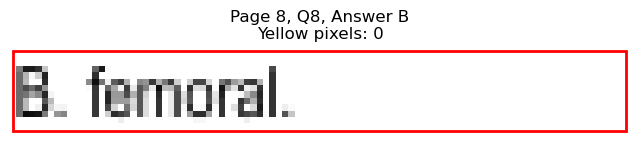

Page 8, Q8 - C: Detected box: x0=315.4, y0=632.2, x1=364.6, y1=644.9
Page 8, Q8, C: Yellow pixels: 1156
Page 8, Q8, C: Total non-white pixels: 1300
Page 8, Q8, C: Yellow percentage: 88.9%


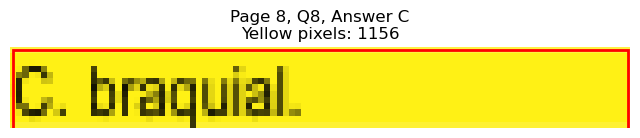

Page 8, Q8 - D: Detected box: x0=315.4, y0=644.8, x1=354.7, y1=657.5
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 157
Page 8, Q8, D: Yellow percentage: 0.0%


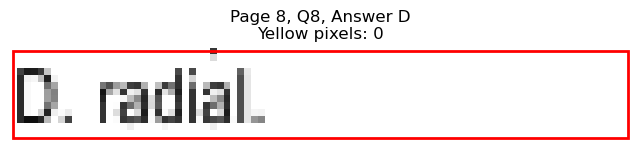


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)
Page 8, Q9 - A: Detected box: x0=56.6, y0=720.6, x1=145.6, y1=733.2
Page 8, Q9, A: Yellow pixels: 0
Page 8, Q9, A: Total non-white pixels: 460
Page 8, Q9, A: Yellow percentage: 0.0%


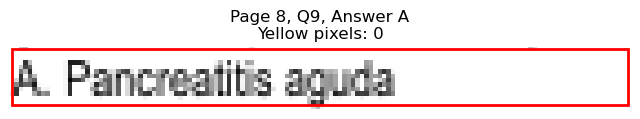

Page 8, Q9 - B: Detected box: x0=56.6, y0=733.2, x1=137.1, y1=745.8
Page 8, Q9, B: Yellow pixels: 0
Page 8, Q9, B: Total non-white pixels: 390
Page 8, Q9, B: Yellow percentage: 0.0%


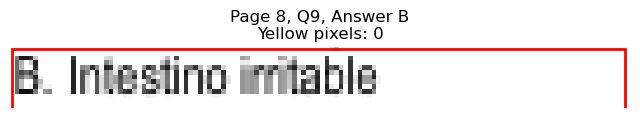

Page 8, Q9 - C: Detected box: x0=315.4, y0=720.6, x1=447.4, y1=733.2
Page 8, Q9, C: Yellow pixels: 183
Page 8, Q9, C: Total non-white pixels: 824
Page 8, Q9, C: Yellow percentage: 22.2%


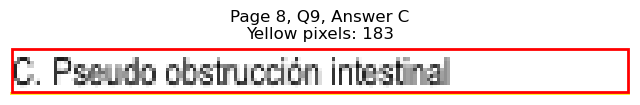

Page 8, Q9 - D: Detected box: x0=315.4, y0=733.2, x1=358.6, y1=745.8
Page 8, Q9, D: Yellow pixels: 1071
Page 8, Q9, D: Total non-white pixels: 1222
Page 8, Q9, D: Yellow percentage: 87.6%


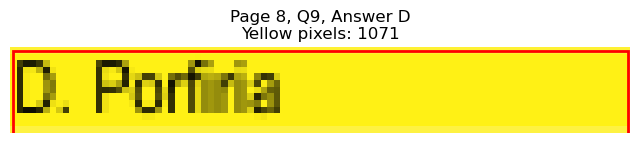


Page 8, Q9 - Selected Answer: D (based on yellow pixel count)

Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=152.1, y1=127.3
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 434
Page 9, Q1, A: Yellow percentage: 0.0%


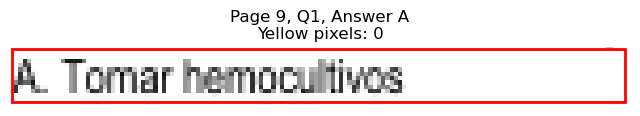

Page 9, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=156.0, y1=139.9
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 466
Page 9, Q1, B: Yellow percentage: 0.0%


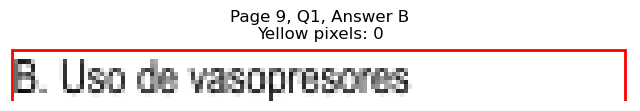

Page 9, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=438.9, y1=127.3
Page 9, Q1, C: Yellow pixels: 174
Page 9, Q1, C: Total non-white pixels: 761
Page 9, Q1, C: Yellow percentage: 22.9%


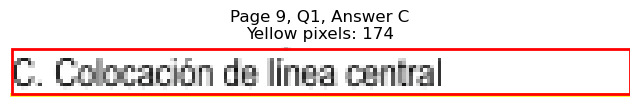

Page 9, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=406.3, y1=139.9
Page 9, Q1, D: Yellow pixels: 1494
Page 9, Q1, D: Total non-white pixels: 1846
Page 9, Q1, D: Yellow percentage: 80.9%


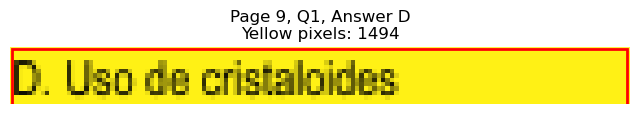


Page 9, Q1 - Selected Answer: D (based on yellow pixel count)
Page 9, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=107.4, y1=190.4
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 261
Page 9, Q2, A: Yellow percentage: 0.0%


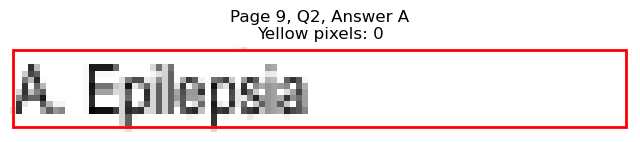

Page 9, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=112.5, y1=203.0
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 275
Page 9, Q2, B: Yellow percentage: 0.0%


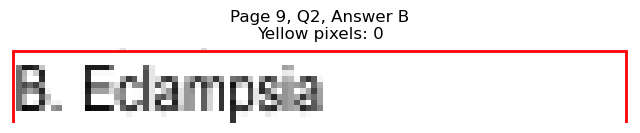

Page 9, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=387.3, y1=190.4
Page 9, Q2, C: Yellow pixels: 123
Page 9, Q2, C: Total non-white pixels: 445
Page 9, Q2, C: Yellow percentage: 27.6%


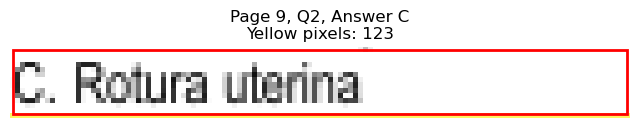

Page 9, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=415.9, y1=203.0
Page 9, Q2, D: Yellow pixels: 1580
Page 9, Q2, D: Total non-white pixels: 1963
Page 9, Q2, D: Yellow percentage: 80.5%


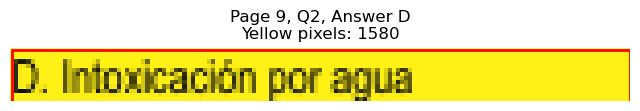


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)
Page 9, Q3 - A: Detected box: x0=56.6, y0=253.4, x1=196.7, y1=266.1
Page 9, Q3, A: Yellow pixels: 1992
Page 9, Q3, A: Total non-white pixels: 2674
Page 9, Q3, A: Yellow percentage: 74.5%


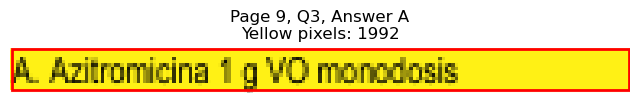

Page 9, Q3 - B: Detected box: x0=56.6, y0=266.0, x1=173.7, y1=278.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 724
Page 9, Q3, B: Yellow percentage: 0.0%


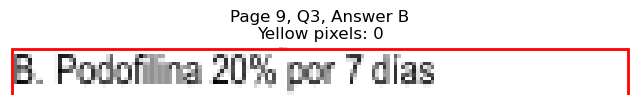

Page 9, Q3 - C: Detected box: x0=315.4, y0=253.4, x1=460.9, y1=266.1
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 668
Page 9, Q3, C: Yellow percentage: 0.0%


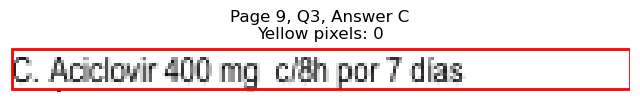

Page 9, Q3 - D: Detected box: x0=315.4, y0=266.0, x1=474.1, y1=278.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 775
Page 9, Q3, D: Yellow percentage: 0.0%


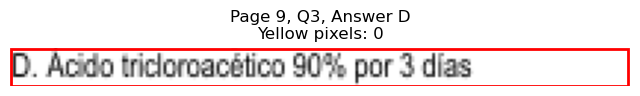


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)
Page 9, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=261.9, y1=329.2
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 946
Page 9, Q4, A: Yellow percentage: 0.0%


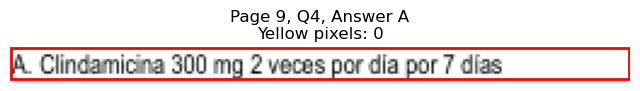

Page 9, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=220.4, y1=341.8
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 778
Page 9, Q4, B: Yellow percentage: 0.0%


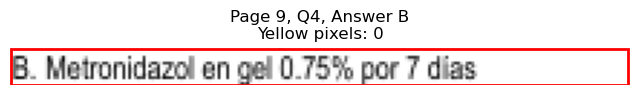

Page 9, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=446.9, y1=329.2
Page 9, Q4, C: Yellow pixels: 1699
Page 9, Q4, C: Total non-white pixels: 2548
Page 9, Q4, C: Yellow percentage: 66.7%


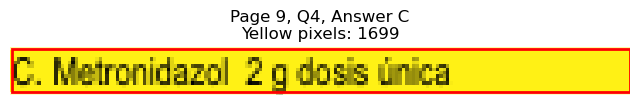

Page 9, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=485.6, y1=341.8
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 1045
Page 9, Q4, D: Yellow percentage: 0.0%


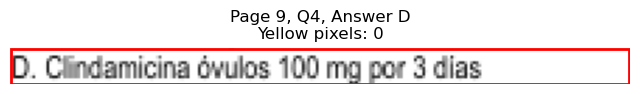


Page 9, Q4 - Selected Answer: C (based on yellow pixel count)
Page 9, Q5 - A: Detected box: x0=56.6, y0=404.9, x1=149.1, y1=417.6
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 432
Page 9, Q5, A: Yellow percentage: 0.0%


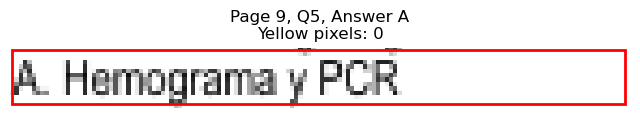

Page 9, Q5 - B: Detected box: x0=56.6, y0=417.6, x1=168.6, y1=430.3
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 580
Page 9, Q5, B: Yellow percentage: 0.0%


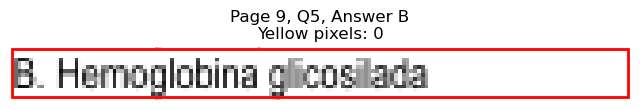

Page 9, Q5 - C: Detected box: x0=315.4, y0=404.9, x1=401.8, y1=417.6
Page 9, Q5, C: Yellow pixels: 1455
Page 9, Q5, C: Total non-white pixels: 1918
Page 9, Q5, C: Yellow percentage: 75.9%


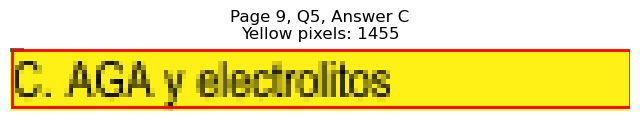

Page 9, Q5 - D: Detected box: x0=315.4, y0=417.6, x1=397.3, y1=430.3
Page 9, Q5, D: Yellow pixels: 133
Page 9, Q5, D: Total non-white pixels: 517
Page 9, Q5, D: Yellow percentage: 25.7%


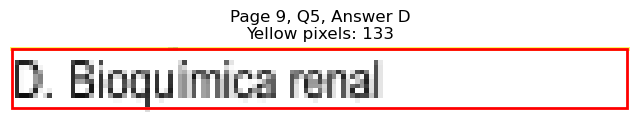


Page 9, Q5 - Selected Answer: C (based on yellow pixel count)
Page 9, Q6 - A: Detected box: x0=56.6, y0=493.4, x1=129.0, y1=506.0
Page 9, Q6, A: Yellow pixels: 1368
Page 9, Q6, A: Total non-white pixels: 1612
Page 9, Q6, A: Yellow percentage: 84.9%


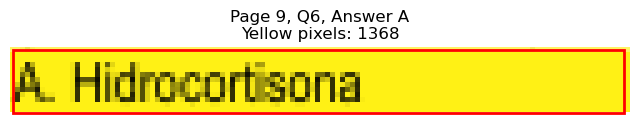

Page 9, Q6 - B: Detected box: x0=56.6, y0=506.0, x1=161.1, y1=518.6
Page 9, Q6, B: Yellow pixels: 156
Page 9, Q6, B: Total non-white pixels: 679
Page 9, Q6, B: Yellow percentage: 23.0%


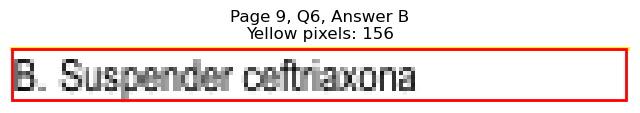

Page 9, Q6 - C: Detected box: x0=315.4, y0=493.4, x1=372.7, y1=506.0
Page 9, Q6, C: Yellow pixels: 0
Page 9, Q6, C: Total non-white pixels: 286
Page 9, Q6, C: Yellow percentage: 0.0%


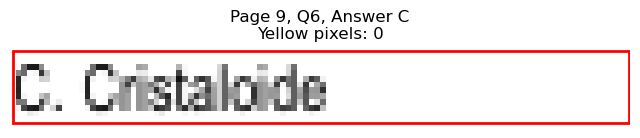

Page 9, Q6 - D: Detected box: x0=315.4, y0=506.0, x1=386.7, y1=518.6
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 360
Page 9, Q6, D: Yellow percentage: 0.0%


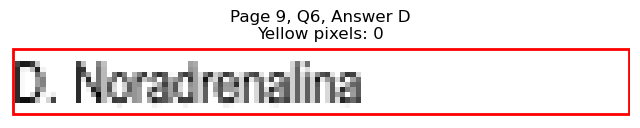


Page 9, Q6 - Selected Answer: A (based on yellow pixel count)
Page 9, Q7 - A: Detected box: x0=56.6, y0=556.5, x1=134.5, y1=569.1
Page 9, Q7, A: Yellow pixels: 1412
Page 9, Q7, A: Total non-white pixels: 1806
Page 9, Q7, A: Yellow percentage: 78.2%


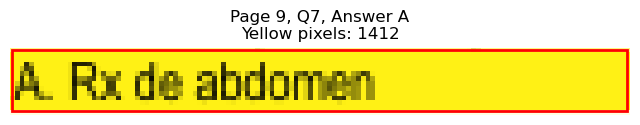

Page 9, Q7 - B: Detected box: x0=56.6, y0=569.1, x1=143.5, y1=581.7
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 534
Page 9, Q7, B: Yellow percentage: 0.0%


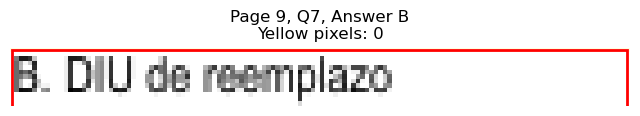

Page 9, Q7 - C: Detected box: x0=315.4, y0=556.5, x1=428.8, y1=569.1
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 542
Page 9, Q7, C: Yellow percentage: 0.0%


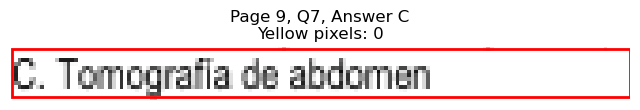

Page 9, Q7 - D: Detected box: x0=315.4, y0=569.1, x1=384.8, y1=581.7
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 317
Page 9, Q7, D: Yellow percentage: 0.0%


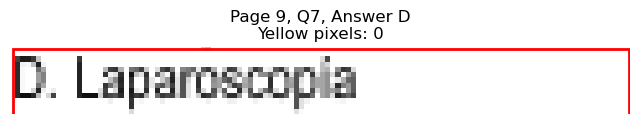


Page 9, Q7 - Selected Answer: A (based on yellow pixel count)
Page 9, Q8 - A: Detected box: x0=56.6, y0=619.6, x1=162.1, y1=632.3
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 523
Page 9, Q8, A: Yellow percentage: 0.0%


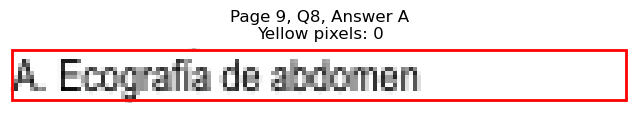

Page 9, Q8 - B: Detected box: x0=56.6, y0=632.2, x1=134.5, y1=644.9
Page 9, Q8, B: Yellow pixels: 0
Page 9, Q8, B: Total non-white pixels: 350
Page 9, Q8, B: Yellow percentage: 0.0%


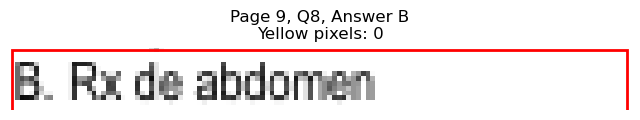

Page 9, Q8 - C: Detected box: x0=315.4, y0=619.6, x1=376.1, y1=632.3
Page 9, Q8, C: Yellow pixels: 1128
Page 9, Q8, C: Total non-white pixels: 1568
Page 9, Q8, C: Yellow percentage: 71.9%


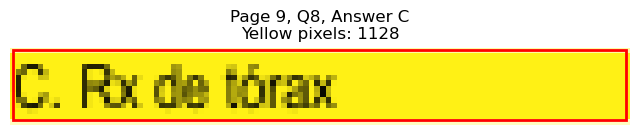

Page 9, Q8 - D: Detected box: x0=315.4, y0=632.2, x1=437.9, y1=644.9
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 785
Page 9, Q8, D: Yellow percentage: 0.0%


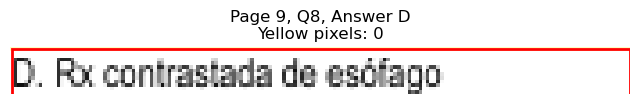


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)
Page 9, Q9 - A: Detected box: x0=56.6, y0=695.4, x1=165.6, y1=708.0
Page 9, Q9, A: Yellow pixels: 160
Page 9, Q9, A: Total non-white pixels: 863
Page 9, Q9, A: Yellow percentage: 18.5%


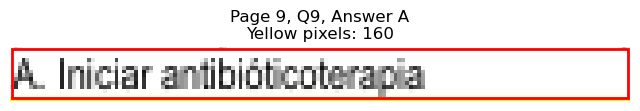

Page 9, Q9 - B: Detected box: x0=56.6, y0=708.0, x1=152.5, y1=720.6
Page 9, Q9, B: Yellow pixels: 1520
Page 9, Q9, B: Total non-white pixels: 2058
Page 9, Q9, B: Yellow percentage: 73.9%


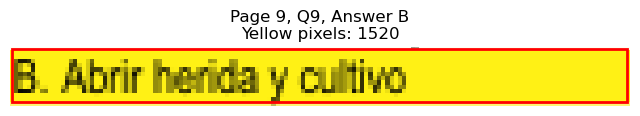

Page 9, Q9 - C: Detected box: x0=315.4, y0=695.4, x1=407.3, y1=708.0
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 438
Page 9, Q9, C: Yellow percentage: 0.0%


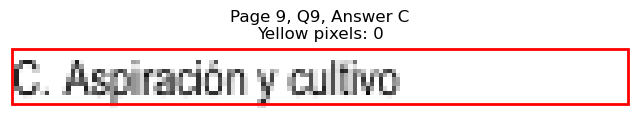

Page 9, Q9 - D: Detected box: x0=315.4, y0=708.0, x1=378.7, y1=720.6
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 333
Page 9, Q9, D: Yellow percentage: 0.0%


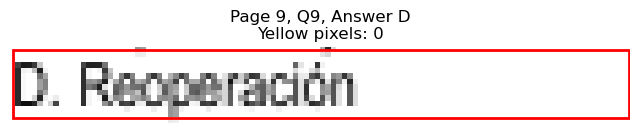


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)

Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=56.6, y0=102.0, x1=123.6, y1=114.7
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 320
Page 10, Q1, A: Yellow percentage: 0.0%


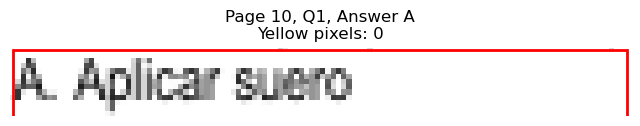

Page 10, Q1 - B: Detected box: x0=56.6, y0=114.6, x1=141.0, y1=127.3
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 381
Page 10, Q1, B: Yellow percentage: 0.0%


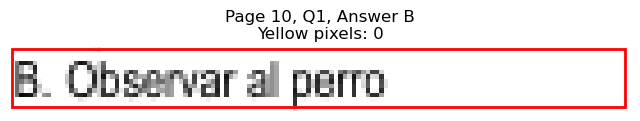

Page 10, Q1 - C: Detected box: x0=315.4, y0=102.0, x1=396.9, y1=114.7
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 517
Page 10, Q1, C: Yellow percentage: 0.0%


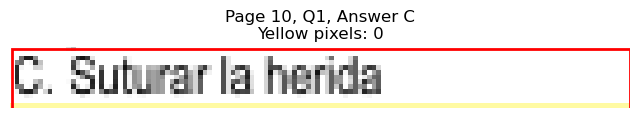

Page 10, Q1 - D: Detected box: x0=315.4, y0=114.6, x1=402.4, y1=127.3
Page 10, Q1, D: Yellow pixels: 1342
Page 10, Q1, D: Total non-white pixels: 1932
Page 10, Q1, D: Yellow percentage: 69.5%


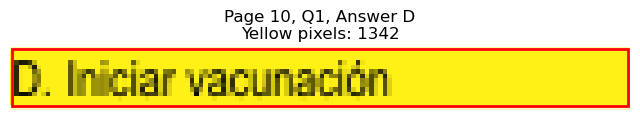


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)
Page 10, Q2 - A: Detected box: x0=56.6, y0=177.7, x1=118.5, y1=190.4
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 286
Page 10, Q2, A: Yellow percentage: 0.0%


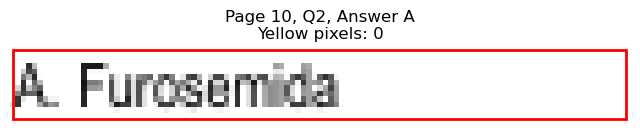

Page 10, Q2 - B: Detected box: x0=56.6, y0=190.3, x1=155.5, y1=203.0
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 504
Page 10, Q2, B: Yellow percentage: 0.0%


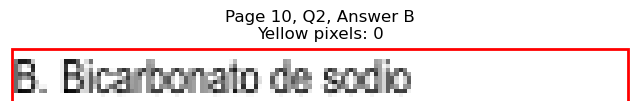

Page 10, Q2 - C: Detected box: x0=315.4, y0=177.7, x1=409.3, y1=190.4
Page 10, Q2, C: Yellow pixels: 1419
Page 10, Q2, C: Total non-white pixels: 2030
Page 10, Q2, C: Yellow percentage: 69.9%


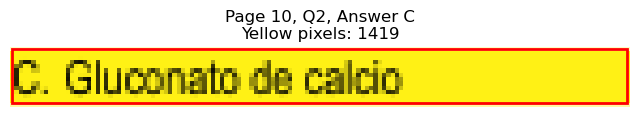

Page 10, Q2 - D: Detected box: x0=315.4, y0=190.3, x1=361.1, y1=203.0
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 315
Page 10, Q2, D: Yellow percentage: 0.0%


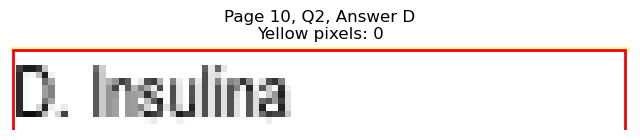


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)
Page 10, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=121.9, y1=278.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 334
Page 10, Q3, A: Yellow percentage: 0.0%


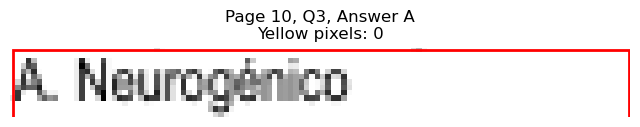

Page 10, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=116.4, y1=291.4
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 280
Page 10, Q3, B: Yellow percentage: 0.0%


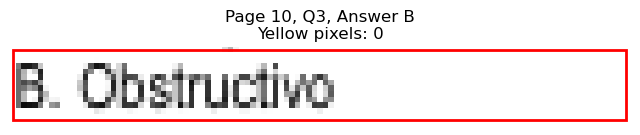

Page 10, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=374.7, y1=278.7
Page 10, Q3, C: Yellow pixels: 1208
Page 10, Q3, C: Total non-white pixels: 1430
Page 10, Q3, C: Yellow percentage: 84.5%


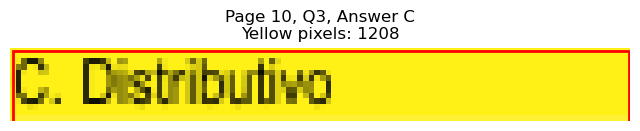

Page 10, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=383.2, y1=291.4
Page 10, Q3, D: Yellow pixels: 119
Page 10, Q3, D: Total non-white pixels: 465
Page 10, Q3, D: Yellow percentage: 25.6%


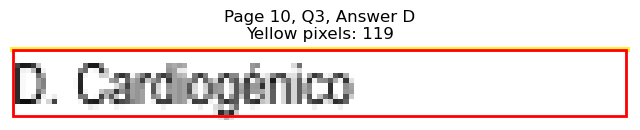


Page 10, Q3 - Selected Answer: C (based on yellow pixel count)
Page 10, Q4 - A: Detected box: x0=56.6, y0=316.6, x1=80.9, y1=329.2
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 104
Page 10, Q4, A: Yellow percentage: 0.0%


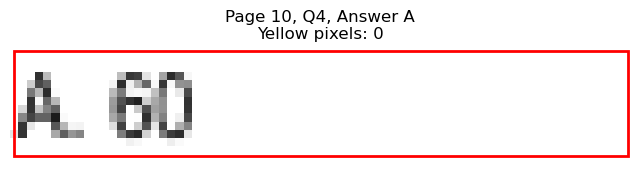

Page 10, Q4 - B: Detected box: x0=56.6, y0=329.2, x1=80.9, y1=341.8
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 109
Page 10, Q4, B: Yellow percentage: 0.0%


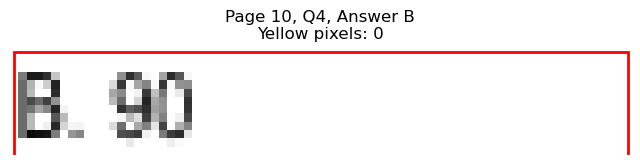

Page 10, Q4 - C: Detected box: x0=315.4, y0=316.6, x1=340.1, y1=329.2
Page 10, Q4, C: Yellow pixels: 849
Page 10, Q4, C: Total non-white pixels: 1064
Page 10, Q4, C: Yellow percentage: 79.8%


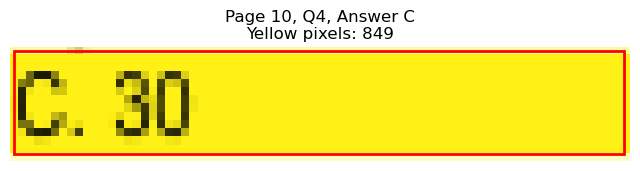

Page 10, Q4 - D: Detected box: x0=315.4, y0=329.2, x1=340.1, y1=341.8
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 160
Page 10, Q4, D: Yellow percentage: 0.0%


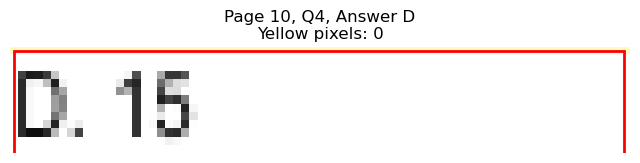


Page 10, Q4 - Selected Answer: C (based on yellow pixel count)
Page 10, Q5 - A: Detected box: x0=56.6, y0=392.3, x1=127.5, y1=405.0
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 472
Page 10, Q5, A: Yellow percentage: 0.0%


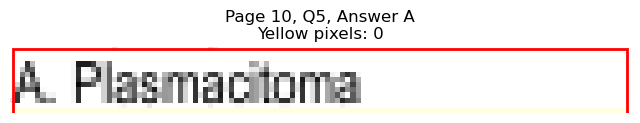

Page 10, Q5 - B: Detected box: x0=56.6, y0=404.9, x1=237.4, y1=417.6
Page 10, Q5, B: Yellow pixels: 2252
Page 10, Q5, B: Total non-white pixels: 3164
Page 10, Q5, B: Yellow percentage: 71.2%


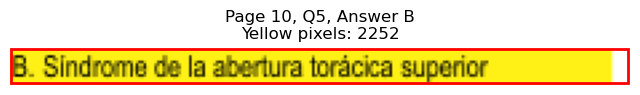

Page 10, Q5 - C: Detected box: x0=315.4, y0=392.3, x1=422.0, y1=405.0
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 522
Page 10, Q5, C: Yellow percentage: 0.0%


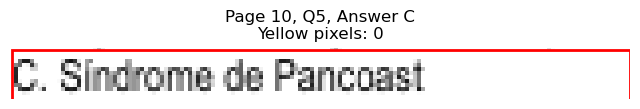

Page 10, Q5 - D: Detected box: x0=315.4, y0=404.9, x1=405.8, y1=417.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 430
Page 10, Q5, D: Yellow percentage: 0.0%


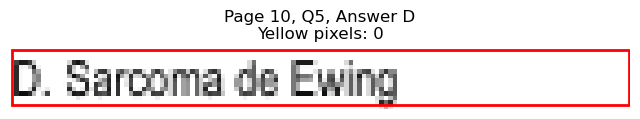


Page 10, Q5 - Selected Answer: B (based on yellow pixel count)
Page 10, Q6 - A: Detected box: x0=56.6, y0=468.1, x1=145.6, y1=480.7
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 489
Page 10, Q6, A: Yellow percentage: 0.0%


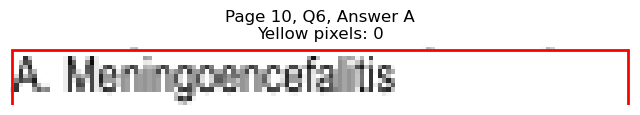

Page 10, Q6 - B: Detected box: x0=56.6, y0=480.8, x1=107.4, y1=493.4
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 269
Page 10, Q6, B: Yellow percentage: 0.0%


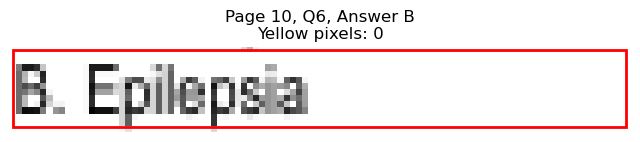

Page 10, Q6 - C: Detected box: x0=315.4, y0=468.1, x1=377.7, y1=480.7
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 300
Page 10, Q6, C: Yellow percentage: 0.0%


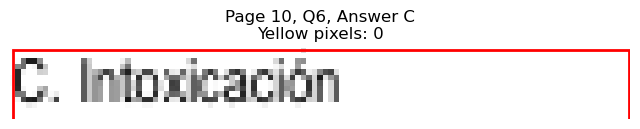

Page 10, Q6 - D: Detected box: x0=315.4, y0=480.8, x1=396.8, y1=493.4
Page 10, Q6, D: Yellow pixels: 1269
Page 10, Q6, D: Total non-white pixels: 1848
Page 10, Q6, D: Yellow percentage: 68.7%


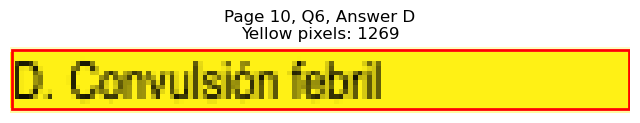


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)
Page 10, Q7 - A: Detected box: x0=56.6, y0=531.2, x1=148.1, y1=543.8
Page 10, Q7, A: Yellow pixels: 1474
Page 10, Q7, A: Total non-white pixels: 1859
Page 10, Q7, A: Yellow percentage: 79.3%


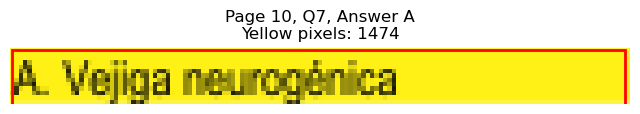

Page 10, Q7 - B: Detected box: x0=56.6, y0=543.8, x1=142.0, y1=556.4
Page 10, Q7, B: Yellow pixels: 126
Page 10, Q7, B: Total non-white pixels: 593
Page 10, Q7, B: Yellow percentage: 21.2%


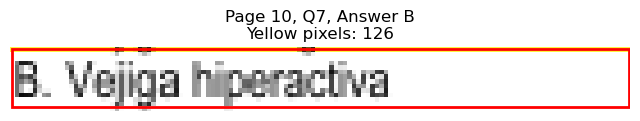

Page 10, Q7 - C: Detected box: x0=315.4, y0=531.2, x1=455.5, y1=543.8
Page 10, Q7, C: Yellow pixels: 0
Page 10, Q7, C: Total non-white pixels: 700
Page 10, Q7, C: Yellow percentage: 0.0%


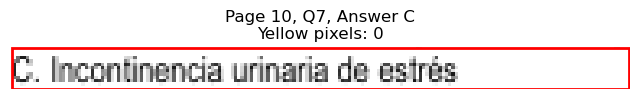

Page 10, Q7 - D: Detected box: x0=315.4, y0=543.8, x1=465.5, y1=556.4
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 732
Page 10, Q7, D: Yellow percentage: 0.0%


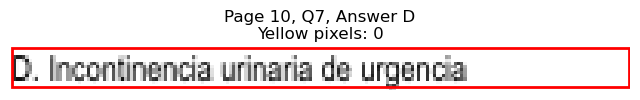


Page 10, Q7 - Selected Answer: A (based on yellow pixel count)
Page 10, Q8 - A: Detected box: x0=56.6, y0=606.9, x1=134.5, y1=619.5
Page 10, Q8, A: Yellow pixels: 1372
Page 10, Q8, A: Total non-white pixels: 1806
Page 10, Q8, A: Yellow percentage: 76.0%


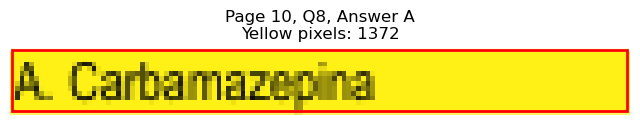

Page 10, Q8 - B: Detected box: x0=56.6, y0=619.6, x1=116.4, y1=632.3
Page 10, Q8, B: Yellow pixels: 111
Page 10, Q8, B: Total non-white pixels: 392
Page 10, Q8, B: Yellow percentage: 28.3%


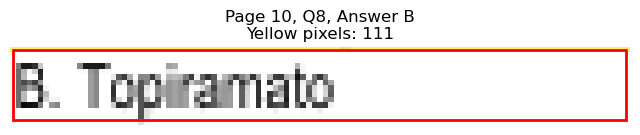

Page 10, Q8 - C: Detected box: x0=315.4, y0=606.9, x1=367.6, y1=619.5
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 237
Page 10, Q8, C: Yellow percentage: 0.0%


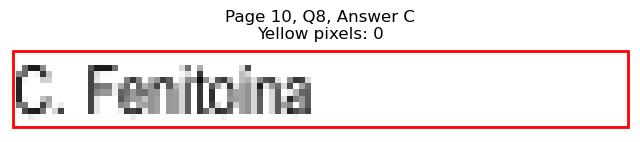

Page 10, Q8 - D: Detected box: x0=315.4, y0=619.6, x1=391.3, y1=632.3
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 364
Page 10, Q8, D: Yellow percentage: 0.0%


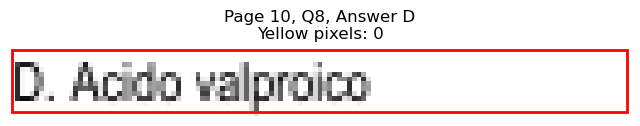


Page 10, Q8 - Selected Answer: A (based on yellow pixel count)
Page 10, Q9 - A: Detected box: x0=56.6, y0=682.6, x1=151.7, y1=695.3
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 437
Page 10, Q9, A: Yellow percentage: 0.0%


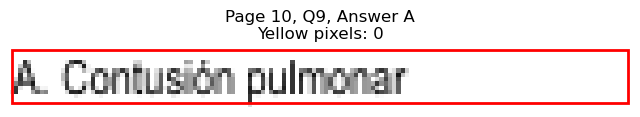

Page 10, Q9 - B: Detected box: x0=56.6, y0=695.4, x1=164.1, y1=708.0
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 528
Page 10, Q9, B: Yellow percentage: 0.0%


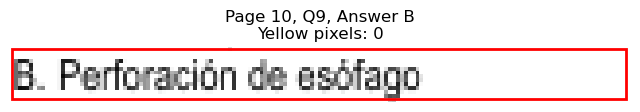

Page 10, Q9 - C: Detected box: x0=315.4, y0=682.6, x1=423.8, y1=695.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 541
Page 10, Q9, C: Yellow percentage: 0.0%


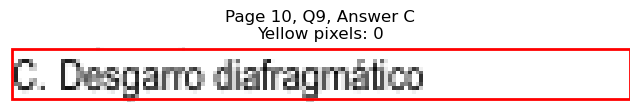

Page 10, Q9 - D: Detected box: x0=315.4, y0=695.4, x1=397.7, y1=708.0
Page 10, Q9, D: Yellow pixels: 1423
Page 10, Q9, D: Total non-white pixels: 1731
Page 10, Q9, D: Yellow percentage: 82.2%


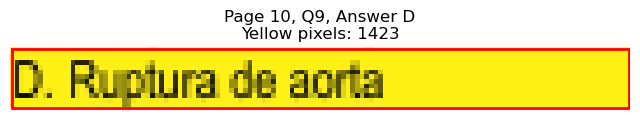


Page 10, Q9 - Selected Answer: D (based on yellow pixel count)
Page 10, Q10 - A: Detected box: x0=56.6, y0=733.2, x1=79.8, y1=745.8
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 197
Page 10, Q10, A: Yellow percentage: 0.0%


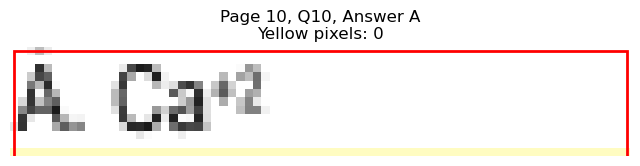

Page 10, Q10 - B: Detected box: x0=83.2, y0=745.8, x1=113.3, y1=758.4
Page 10, Q10, B: Yellow pixels: 953
Page 10, Q10, B: Total non-white pixels: 1134
Page 10, Q10, B: Yellow percentage: 84.0%


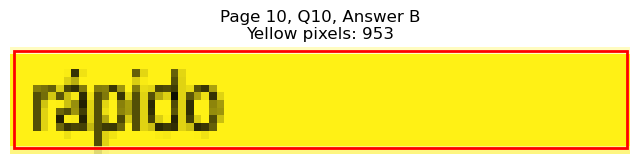

Page 10, Q10 - C: Detected box: x0=336.9, y0=733.2, x1=416.1, y1=745.8
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 379
Page 10, Q10, C: Yellow percentage: 0.0%


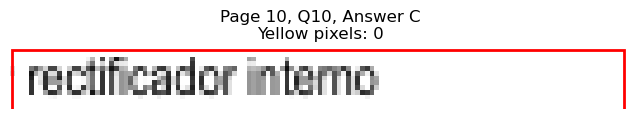

Page 10, Q10 - D: Detected box: x0=336.9, y0=745.8, x1=400.2, y1=758.4
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 291
Page 10, Q10, D: Yellow percentage: 0.0%


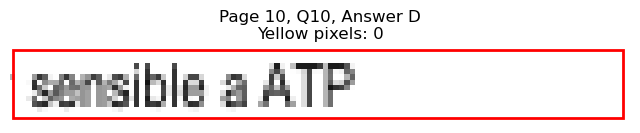


Page 10, Q10 - Selected Answer: B (based on yellow pixel count)

Page 11: Found 7 questions
Page 11, Q1 - A: Detected box: x0=56.6, y0=114.6, x1=123.5, y1=127.3
Page 11, Q1, A: Yellow pixels: 1160
Page 11, Q1, A: Total non-white pixels: 1652
Page 11, Q1, A: Yellow percentage: 70.2%


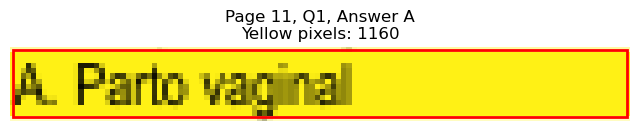

Page 11, Q1 - B: Detected box: x0=56.6, y0=127.2, x1=180.1, y1=139.9
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 763
Page 11, Q1, B: Yellow percentage: 0.0%


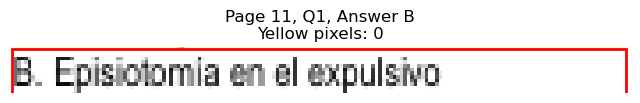

Page 11, Q1 - C: Detected box: x0=315.4, y0=114.6, x1=426.3, y1=127.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 544
Page 11, Q1, C: Yellow percentage: 0.0%


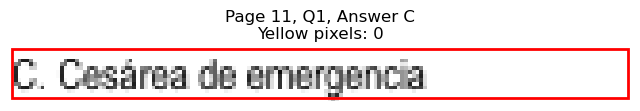

Page 11, Q1 - D: Detected box: x0=315.4, y0=127.2, x1=411.3, y1=139.9
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 453
Page 11, Q1, D: Yellow percentage: 0.0%


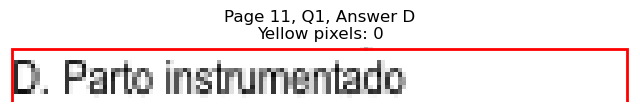


Page 11, Q1 - Selected Answer: A (based on yellow pixel count)
Page 11, Q2 - A: Detected box: x0=56.6, y0=190.3, x1=144.0, y1=203.0
Page 11, Q2, A: Yellow pixels: 0
Page 11, Q2, A: Total non-white pixels: 560
Page 11, Q2, A: Yellow percentage: 0.0%


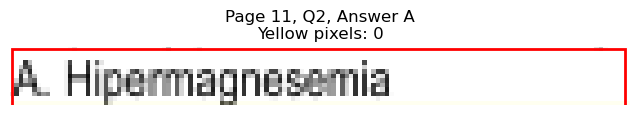

Page 11, Q2 - B: Detected box: x0=56.6, y0=202.9, x1=120.5, y1=215.6
Page 11, Q2, B: Yellow pixels: 1250
Page 11, Q2, B: Total non-white pixels: 1610
Page 11, Q2, B: Yellow percentage: 77.6%


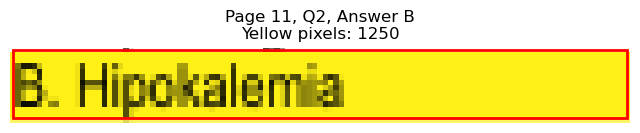

Page 11, Q2 - C: Detected box: x0=315.4, y0=190.3, x1=382.7, y1=203.0
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 337
Page 11, Q2, C: Yellow percentage: 0.0%


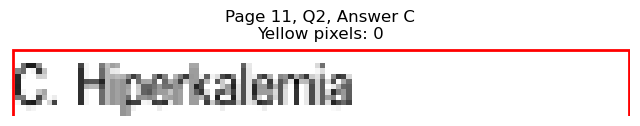

Page 11, Q2 - D: Detected box: x0=315.4, y0=202.9, x1=384.2, y1=215.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 352
Page 11, Q2, D: Yellow percentage: 0.0%


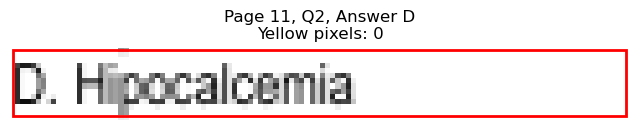


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)
Page 11, Q3 - A: Detected box: x0=56.6, y0=266.0, x1=157.1, y1=278.7
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 499
Page 11, Q3, A: Yellow percentage: 0.0%


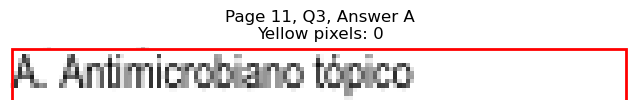

Page 11, Q3 - B: Detected box: x0=56.6, y0=278.8, x1=138.0, y1=291.4
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 415
Page 11, Q3, B: Yellow percentage: 0.0%


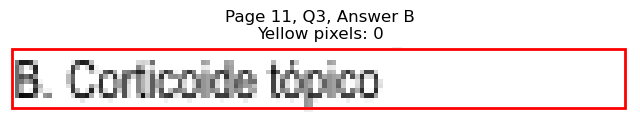

Page 11, Q3 - C: Detected box: x0=315.4, y0=266.0, x1=389.2, y1=278.7
Page 11, Q3, C: Yellow pixels: 1358
Page 11, Q3, C: Total non-white pixels: 1625
Page 11, Q3, C: Yellow percentage: 83.6%


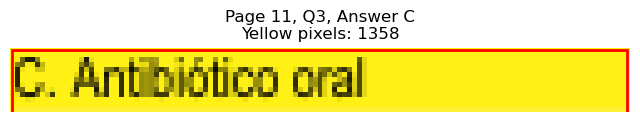

Page 11, Q3 - D: Detected box: x0=315.4, y0=278.8, x1=408.8, y1=291.4
Page 11, Q3, D: Yellow pixels: 144
Page 11, Q3, D: Total non-white pixels: 609
Page 11, Q3, D: Yellow percentage: 23.6%


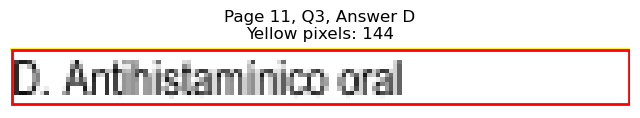


Page 11, Q3 - Selected Answer: C (based on yellow pixel count)
Page 11, Q4 - A: Detected box: x0=56.6, y0=341.9, x1=158.1, y1=354.6
Page 11, Q4, A: Yellow pixels: 1630
Page 11, Q4, A: Total non-white pixels: 2142
Page 11, Q4, A: Yellow percentage: 76.1%


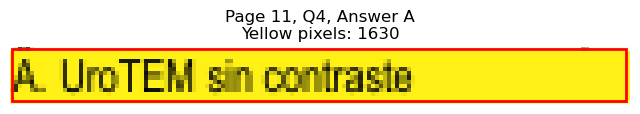

Page 11, Q4 - B: Detected box: x0=56.6, y0=354.5, x1=132.0, y1=367.2
Page 11, Q4, B: Yellow pixels: 127
Page 11, Q4, B: Total non-white pixels: 483
Page 11, Q4, B: Yellow percentage: 26.3%


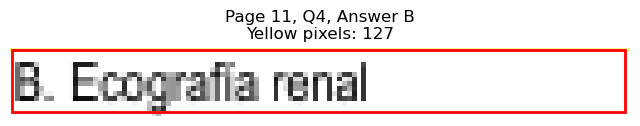

Page 11, Q4 - C: Detected box: x0=315.4, y0=341.9, x1=409.7, y1=354.6
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 466
Page 11, Q4, C: Yellow percentage: 0.0%


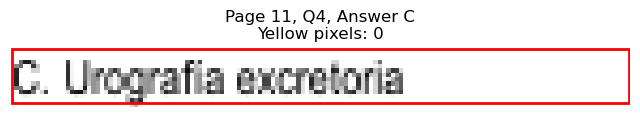

Page 11, Q4 - D: Detected box: x0=315.4, y0=354.5, x1=458.0, y1=367.2
Page 11, Q4, D: Yellow pixels: 0
Page 11, Q4, D: Total non-white pixels: 736
Page 11, Q4, D: Yellow percentage: 0.0%


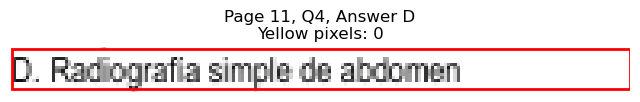


Page 11, Q4 - Selected Answer: A (based on yellow pixel count)
Page 11, Q5 - A: Detected box: x0=56.6, y0=417.6, x1=130.0, y1=430.3
Page 11, Q5, A: Yellow pixels: 1227
Page 11, Q5, A: Total non-white pixels: 1736
Page 11, Q5, A: Yellow percentage: 70.7%


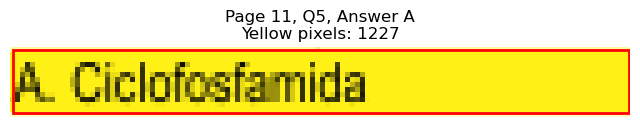

Page 11, Q5 - B: Detected box: x0=56.6, y0=430.2, x1=121.9, y1=442.9
Page 11, Q5, B: Yellow pixels: 0
Page 11, Q5, B: Total non-white pixels: 463
Page 11, Q5, B: Yellow percentage: 0.0%


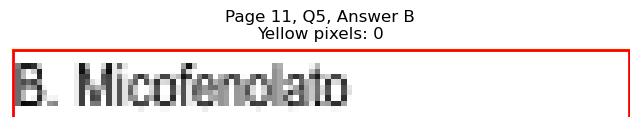

Page 11, Q5 - C: Detected box: x0=315.4, y0=417.6, x1=390.8, y1=430.3
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 353
Page 11, Q5, C: Yellow percentage: 0.0%


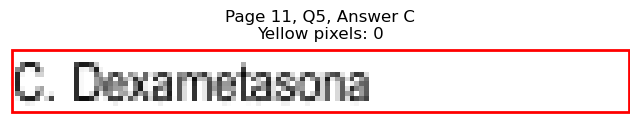

Page 11, Q5 - D: Detected box: x0=315.4, y0=430.2, x1=377.7, y1=442.9
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 314
Page 11, Q5, D: Yellow percentage: 0.0%


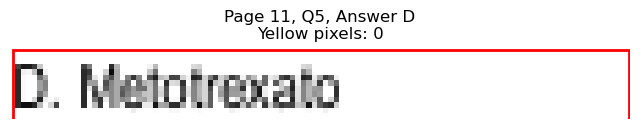


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)
Page 11, Q6 - A: Detected box: x0=56.6, y0=480.8, x1=171.1, y1=493.4
Page 11, Q6, A: Yellow pixels: 0
Page 11, Q6, A: Total non-white pixels: 527
Page 11, Q6, A: Yellow percentage: 0.0%


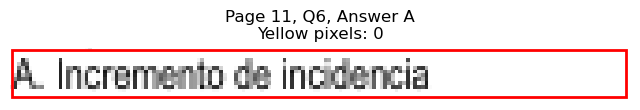

Page 11, Q6 - B: Detected box: x0=56.6, y0=493.4, x1=181.1, y1=506.0
Page 11, Q6, B: Yellow pixels: 0
Page 11, Q6, B: Total non-white pixels: 597
Page 11, Q6, B: Yellow percentage: 0.0%


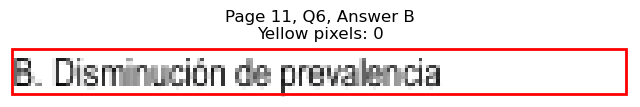

Page 11, Q6 - C: Detected box: x0=315.4, y0=480.8, x1=434.3, y1=493.4
Page 11, Q6, C: Yellow pixels: 170
Page 11, Q6, C: Total non-white pixels: 773
Page 11, Q6, C: Yellow percentage: 22.0%


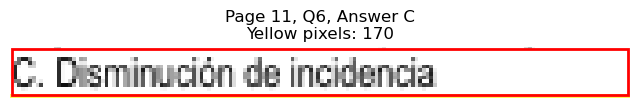

Page 11, Q6 - D: Detected box: x0=315.4, y0=493.4, x1=436.4, y1=506.0
Page 11, Q6, D: Yellow pixels: 1778
Page 11, Q6, D: Total non-white pixels: 2237
Page 11, Q6, D: Yellow percentage: 79.5%


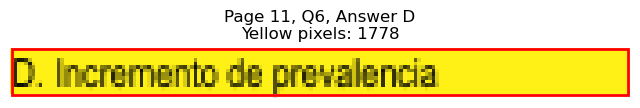


Page 11, Q6 - Selected Answer: D (based on yellow pixel count)
Page 11, Q7 - A: Detected box: x0=56.6, y0=569.1, x1=200.8, y1=581.7
Page 11, Q7, A: Yellow pixels: 2
Page 11, Q7, A: Total non-white pixels: 906
Page 11, Q7, A: Yellow percentage: 0.2%


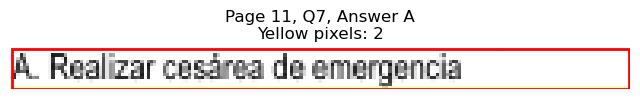

Page 11, Q7 - B: Detected box: x0=56.6, y0=581.7, x1=256.4, y1=594.3
Page 11, Q7, B: Yellow pixels: 1965
Page 11, Q7, B: Total non-white pixels: 3164
Page 11, Q7, B: Yellow percentage: 62.1%


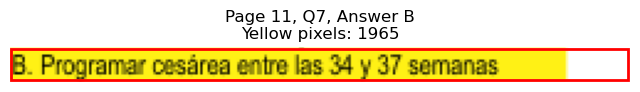

Page 11, Q7 - C: Detected box: x0=315.4, y0=569.1, x1=519.1, y1=581.7
Page 11, Q7, C: Yellow pixels: 0
Page 11, Q7, C: Total non-white pixels: 1008
Page 11, Q7, C: Yellow percentage: 0.0%


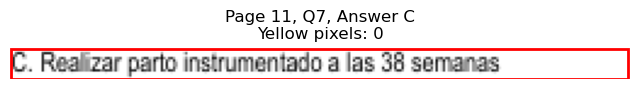

Page 11, Q7 - D: Detected box: x0=315.4, y0=581.7, x1=477.9, y1=594.3
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 774
Page 11, Q7, D: Yellow percentage: 0.0%


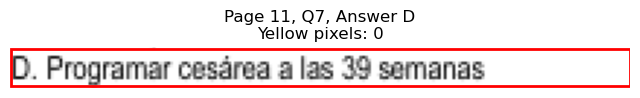


Page 11, Q7 - Selected Answer: B (based on yellow pixel count)


In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 45 años, que labora como operaria de ...
1   Mujer de 70 años con diagnóstico de pancreatit...
2   Lactante de 10 meses, irritable, piel con lesi...
3   En la RCP básica de alta calidad del lactante ...
4   Neonato de 5 días, es traído por madre quien r...
..                                                ...
95  Adolescente de 15 años, acude a consultorio po...
96  Varón de 40 años acude por dolor en región lum...
97  Mujer de 36 años con antecedente de LES activo...
98  Se cuenta con un excelente programa de manejo ...
99  Tercigesta de 32 semanas, antecedente de 2 ces...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                           Rótula   
1            Neoplasia pancreática   
2                       Tacrolimus   
3                             30/2   
4              Incompatibilidad Rh   
..                             ...   
95           Antimicrobiano tópico   
96            UroTEM sin contraste   
97                  Ciclofosfamida   
98        Incremento de incidencia   
99  Realizar cesárea de emergencia   

                                       option_B  \
0                                      Meniscos   
1            Acumulación de líquido pancreático   
2                                       Lindano   
3                                          15/2   
4                         Fallo de la lactancia   
..                                          ...   
95                            Corticoide tópico   
96                              Ecografía renal   
97                                 Micofenolato   
98                   Disminución de prevalencia   
99  Programar cesárea entre las 34 y 37 semanas   

                                         option_C  \
0                             Bursa de la rodilla   
1                     Acumulación necrótica aguda   
2                                Permetrina al 5%   
3                                            40/1   
4                                Hepatitis del RN   
..                                            ...   
95                               Antibiótico oral   
96                           Urografía excretoria   
97                                   Dexametasona   
98                      Disminución de incidencia   
99  Realizar parto instrumentado a las 38 semanas   

                              option_D  
0                    Ligamento cruzado  
1              Seudoquiste pancreático  
2                     Mometasona al 1%  
3                                 40/2  
4                       Cefalohematoma  
..                                 ...  
95                Antihistamínico oral  
96       Radiografía simple de abdomen  
97                         Metotrexato  
98           Incremento de prevalencia  
99  Programar cesárea a las 39 semanas  

[100 rows x 4 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               D
2               C
3               A
4               B
..            ...
95              C
96              A
97              A
98              D
99              B

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "correct_answer"]
total_df

questions  \
0   Mujer de 45 años, que labora como operaria de ...   
1   Mujer de 70 años con diagnóstico de pancreatit...   
2   Lactante de 10 meses, irritable, piel con lesi...   
3   En la RCP básica de alta calidad del lactante ...   
4   Neonato de 5 días, es traído por madre quien r...   
..                                                ...   
95  Adolescente de 15 años, acude a consultorio po...   
96  Varón de 40 años acude por dolor en región lum...   
97  Mujer de 36 años con antecedente de LES activo...   
98  Se cuenta con un excelente programa de manejo ...   
99  Tercigesta de 32 semanas, antecedente de 2 ces...   

                          option_A  \
0                           Rótula   
1            Neoplasia pancreática   
2                       Tacrolimus   
3                             30/2   
4              Incompatibilidad Rh   
..                             ...   
95           Antimicrobiano tópico   
96            UroTEM sin contraste   
97                  Ciclofosfamida   
98        Incremento de incidencia   
99  Realizar cesárea de emergencia   

                                       option_B  \
0                                      Meniscos   
1            Acumulación de líquido pancreático   
2                                       Lindano   
3                                          15/2   
4                         Fallo de la lactancia   
..                                          ...   
95                            Corticoide tópico   
96                              Ecografía renal   
97                                 Micofenolato   
98                   Disminución de prevalencia   
99  Programar cesárea entre las 34 y 37 semanas   

                                         option_C  \
0                             Bursa de la rodilla   
1                     Acumulación necrótica aguda   
2                                Permetrina al 5%   
3                                            40/1   
4                                Hepatitis del RN   
..                                            ...   
95                               Antibiótico oral   
96                           Urografía excretoria   
97                                   Dexametasona   
98                      Disminución de incidencia   
99  Realizar parto instrumentado a las 38 semanas   

                              option_D correct_answer  
0                    Ligamento cruzado              C  
1              Seudoquiste pancreático              D  
2                     Mometasona al 1%              C  
3                                 40/2              A  
4                       Cefalohematoma              B  
..                                 ...            ...  
95                Antihistamínico oral              C  
96       Radiografía simple de abdomen              A  
97                         Metotrexato              A  
98           Incremento de prevalencia              D  
99  Programar cesárea a las 39 semanas              B  

[100 rows x 6 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2024/ESPECIALIADAD B.csv
